# <font color='blue'>CA2 Project: Drought in Mexico</font>
## Denisse Guadarrama

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from pmdarima import ARIMA
from pmdarima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

The data is in an xlsx file

The file contains information on drought levels, organized by city and state, reported since January 2003 and recorded biweekly

In [2]:
file_name = "sequia2023.xlsx"

In [3]:
sheet_name = 0
df = pd.read_excel(file_name, sheet_name=sheet_name)

In [4]:
df.head()

CVE_CONCATENADA  CVE_ENT  CVE_MUN      NOMBRE_MUN         ENTIDAD  \
0             1001        1        1  Aguascalientes  Aguascalientes   
1             1002        1        2        Asientos  Aguascalientes   
2             1003        1        3        Calvillo  Aguascalientes   
3             1004        1        4           Cosío  Aguascalientes   
4             1005        1        5     Jesús María  Aguascalientes   

                ORG_CUENCA CLV_OC    CON_CUENCA  CVE_CONC 2003-01-31 00:00:00  \
0  Lerma Santiago Pacífico   VIII  Rio Santiago        16                 NaN   
1  Lerma Santiago Pacífico   VIII  Rio Santiago        16                 NaN   
2  Lerma Santiago Pacífico   VIII  Rio Santiago        16                 NaN   
3  Lerma Santiago Pacífico   VIII  Rio Santiago        16                 NaN   
4  Lerma Santiago Pacífico   VIII  Rio Santiago        16                 NaN   

   ... 2023-08-15 00:00:00 2023-08-31 00:00:00 2023-09-15 00:00:00  \
0  ...                  D3                  D3                  D3   
1  ...                  D3                  D3                  D3   
2  ...                  D3                  D3                  D3   
3  ...                  D2                  D2                  D3   
4  ...                  D3                  D3                  D3   

  2023-09-30 00:00:00 2023-10-15 00:00:00 2023-10-31 00:00:00  \
0                  D3                  D3                  D3   
1                  D3                  D3                  D3   
2                  D3                  D3                  D3   
3                  D3                  D3                  D3   
4                  D3                  D3                  D3   

   2023-11-15 00:00:00 2023-11-30 00:00:00 2023-12-15 00:00:00  \
0                   D3                  D3                  D1   
1                   D3                  D2                  D1   
2                   D3                  D3                  D3   
3                   D3                  D3                  D2   
4                   D3                  D3                  D2   

  2023-12-31 00:00:00  
0                  D1  
1                  D1  
2                  D3  
3                  D2  
4                  D2  

[5 rows x 379 columns]

#### Removing columns

We will remove the unnecessary columns, as the majority of them are identification keys.

We will also remove the cities from each state, as our focus will be uniquely on states. We only need to know the state and the historical data of the droughts.

In [5]:
df = df.drop(columns=["CVE_CONCATENADA","CVE_ENT","CVE_MUN","NOMBRE_MUN", "ORG_CUENCA", "CLV_OC","CVE_CONC","CON_CUENCA","CVE_CONC"])

In [6]:
df.head()

ENTIDAD 2003-01-31 00:00:00 2003-02-28 00:00:00 2003-03-31 00:00:00  \
0  Aguascalientes                 NaN                 NaN                 NaN   
1  Aguascalientes                 NaN                 NaN                 NaN   
2  Aguascalientes                 NaN                 NaN                 NaN   
3  Aguascalientes                 NaN                 NaN                 NaN   
4  Aguascalientes                 NaN                 NaN                 NaN   

  2003-04-30 00:00:00 2003-05-31 00:00:00 2003-06-30 00:00:00  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

  2003-07-31 00:00:00  2003-08-31 00:00:00 2003-09-30 00:00:00  ...  \
0                 NaN                  NaN                 NaN  ...   
1                 NaN                  NaN                 NaN  ...   
2                 NaN                  NaN                 NaN  ...   
3                 NaN                  NaN                 NaN  ...   
4                 NaN                  NaN                 NaN  ...   

  2023-08-15 00:00:00 2023-08-31 00:00:00 2023-09-15 00:00:00  \
0                  D3                  D3                  D3   
1                  D3                  D3                  D3   
2                  D3                  D3                  D3   
3                  D2                  D2                  D3   
4                  D3                  D3                  D3   

  2023-09-30 00:00:00  2023-10-15 00:00:00 2023-10-31 00:00:00  \
0                  D3                   D3                  D3   
1                  D3                   D3                  D3   
2                  D3                   D3                  D3   
3                  D3                   D3                  D3   
4                  D3                   D3                  D3   

  2023-11-15 00:00:00 2023-11-30 00:00:00 2023-12-15 00:00:00  \
0                  D3                  D3                  D1   
1                  D3                  D2                  D1   
2                  D3                  D3                  D3   
3                  D3                  D3                  D2   
4                  D3                  D3                  D2   

  2023-12-31 00:00:00  
0                  D1  
1                  D1  
2                  D3  
3                  D2  
4                  D2  

[5 rows x 371 columns]

#### Replacing the drought levels with numerical values as follows:

1. Minimum (10% water reduction) D0 = 1

2. Moderate (15%) D1= 2
   
3. Moderate (25%) D2= 3

4. Severe (40%) D3= 4

5. Critical (>40%) D4= 5

In [7]:
df_replace = df.replace({'D0': 1,'D1':2,'D2':3,'D3':4,'D4':5})

#### Missing values:

All NA values do not indicate missing data; rather, they signify that no drought was reported on those days. Therefore, we will replace them with 0.

In [8]:
df_replace=df_replace.fillna(0)

In [9]:
df_replace.head()

ENTIDAD  2003-01-31 00:00:00  2003-02-28 00:00:00  \
0  Aguascalientes                  0.0                  0.0   
1  Aguascalientes                  0.0                  0.0   
2  Aguascalientes                  0.0                  0.0   
3  Aguascalientes                  0.0                  0.0   
4  Aguascalientes                  0.0                  0.0   

   2003-03-31 00:00:00  2003-04-30 00:00:00  2003-05-31 00:00:00  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   2003-06-30 00:00:00  2003-07-31 00:00:00  2003-08-31 00:00:00  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   2003-09-30 00:00:00  ...  2023-08-15 00:00:00  2023-08-31 00:00:00  \
0                  0.0  ...                  4.0                  4.0   
1                  0.0  ...                  4.0                  4.0   
2                  0.0  ...                  4.0                  4.0   
3                  0.0  ...                  3.0                  3.0   
4                  0.0  ...                  4.0                  4.0   

   2023-09-15 00:00:00  2023-09-30 00:00:00  2023-10-15 00:00:00  \
0                  4.0                  4.0                  4.0   
1                  4.0                  4.0                  4.0   
2                  4.0                  4.0                  4.0   
3                  4.0                  4.0                  4.0   
4                  4.0                  4.0                  4.0   

   2023-10-31 00:00:00  2023-11-15 00:00:00  2023-11-30 00:00:00  \
0                  4.0                  4.0                  4.0   
1                  4.0                  4.0                  3.0   
2                  4.0                  4.0                  4.0   
3                  4.0                  4.0                  4.0   
4                  4.0                  4.0                  4.0   

   2023-12-15 00:00:00  2023-12-31 00:00:00  
0                  2.0                  2.0  
1                  2.0                  2.0  
2                  4.0                  4.0  
3                  3.0                  3.0  
4                  3.0                  3.0  

[5 rows x 371 columns]

The 'Entidad' column contains the states of the country, repeated because the database is divided into cities. However, our objective is to determine the drought level by state. Therefore, the maximum value will be taken, meaning the highest drought level among all the cities belonging to a specific state will be assigned to the state. This approach is preferred because if there is a possibility that one city within the state has a high drought level, it is more prudent to consider the most critical situation rather than the average, for example.

In [10]:
df_replace["ENTIDAD"].unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila de Zaragoza', 'Colima', 'Chiapas',
       'Chihuahua', 'Ciudad de México', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'Estado de México',
       'Michoacán de Ocampo', 'Morelos', 'Nayarit', 'Nuevo León',
       'Oaxaca', 'Puebla', 'Querétaro de Arteaga', 'Quintana Roo',
       'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas',
       'Tlaxcala', 'Veracruz de Ignacio de la Llave', 'Yucatán',
       'Zacatecas'], dtype=object)

In [11]:
max = df_replace.groupby('ENTIDAD').max()

new_df = pd.DataFrame(max)
print(new_df)

                                 2003-01-31  2003-02-28  2003-03-31  \
ENTIDAD                                                               
Aguascalientes                          0.0         0.0         0.0   
Baja California                         4.0         3.0         2.0   
Baja California Sur                     3.0         3.0         3.0   
Campeche                                1.0         2.0         2.0   
Chiapas                                 2.0         2.0         2.0   
Chihuahua                               4.0         4.0         4.0   
Ciudad de México                        1.0         1.0         1.0   
Coahuila de Zaragoza                    3.0         3.0         3.0   
Colima                                  0.0         0.0         0.0   
Durango                                 3.0         3.0         3.0   
Estado de México                        2.0         2.0         2.0   
Guanajuato                              0.0         0.0         0.0   
Guerre

In [12]:
new_df.head()

2003-01-31  2003-02-28  2003-03-31  2003-04-30  \
ENTIDAD                                                               
Aguascalientes              0.0         0.0         0.0         0.0   
Baja California             4.0         3.0         2.0         2.0   
Baja California Sur         3.0         3.0         3.0         3.0   
Campeche                    1.0         2.0         2.0         2.0   
Chiapas                     2.0         2.0         2.0         2.0   

                     2003-05-31  2003-06-30  2003-07-31  2003-08-31  \
ENTIDAD                                                               
Aguascalientes              0.0         0.0         0.0         0.0   
Baja California             2.0         2.0         2.0         0.0   
Baja California Sur         3.0         2.0         2.0         0.0   
Campeche                    2.0         1.0         1.0         0.0   
Chiapas                     2.0         1.0         2.0         0.0   

                     2003-09-30  2003-10-31  ...  2023-08-15  2023-08-31  \
ENTIDAD                                      ...                           
Aguascalientes              0.0         0.0  ...         4.0         4.0   
Baja California             1.0         1.0  ...         1.0         1.0   
Baja California Sur         0.0         0.0  ...         1.0         0.0   
Campeche                    1.0         1.0  ...         2.0         2.0   
Chiapas                     1.0         1.0  ...         3.0         3.0   

                     2023-09-15  2023-09-30  2023-10-15  2023-10-31  \
ENTIDAD                                                               
Aguascalientes              4.0         4.0         4.0         4.0   
Baja California             0.0         0.0         0.0         0.0   
Baja California Sur         0.0         0.0         0.0         0.0   
Campeche                    2.0         2.0         2.0         2.0   
Chiapas                     3.0         3.0         3.0         3.0   

                     2023-11-15  2023-11-30  2023-12-15  2023-12-31  
ENTIDAD                                                              
Aguascalientes              4.0         4.0         4.0         4.0  
Baja California             0.0         0.0         0.0         0.0  
Baja California Sur         0.0         0.0         0.0         0.0  
Campeche                    2.0         2.0         2.0         2.0  
Chiapas                     3.0         3.0         3.0         3.0  

[5 rows x 370 columns]

We will create a new dataframe containing the maximum values and transpose it, so that each state is represented in a separate column.

In [13]:
df_trans = new_df.T 
df_trans.head()

ENTIDAD              Aguascalientes  Baja California  Baja California Sur  \
2003-01-31 00:00:00             0.0              4.0                  3.0   
2003-02-28 00:00:00             0.0              3.0                  3.0   
2003-03-31 00:00:00             0.0              2.0                  3.0   
2003-04-30 00:00:00             0.0              2.0                  3.0   
2003-05-31 00:00:00             0.0              2.0                  3.0   

ENTIDAD              Campeche  Chiapas  Chihuahua  Ciudad de México  \
2003-01-31 00:00:00       1.0      2.0        4.0               1.0   
2003-02-28 00:00:00       2.0      2.0        4.0               1.0   
2003-03-31 00:00:00       2.0      2.0        4.0               1.0   
2003-04-30 00:00:00       2.0      2.0        4.0               1.0   
2003-05-31 00:00:00       2.0      2.0        4.0               1.0   

ENTIDAD              Coahuila de Zaragoza  Colima  Durango  ...  Quintana Roo  \
2003-01-31 00:00:00                   3.0     0.0      3.0  ...           0.0   
2003-02-28 00:00:00                   3.0     0.0      3.0  ...           0.0   
2003-03-31 00:00:00                   3.0     0.0      3.0  ...           0.0   
2003-04-30 00:00:00                   3.0     0.0      3.0  ...           0.0   
2003-05-31 00:00:00                   3.0     0.0      3.0  ...           0.0   

ENTIDAD              San Luis Potosí  Sinaloa  Sonora  Tabasco  Tamaulipas  \
2003-01-31 00:00:00              1.0      5.0     5.0      2.0         2.0   
2003-02-28 00:00:00              1.0      5.0     5.0      2.0         2.0   
2003-03-31 00:00:00              1.0      5.0     5.0      2.0         1.0   
2003-04-30 00:00:00              1.0      5.0     5.0      2.0         1.0   
2003-05-31 00:00:00              1.0      5.0     5.0      2.0         1.0   

ENTIDAD              Tlaxcala  Veracruz de Ignacio de la Llave  Yucatán  \
2003-01-31 00:00:00       1.0                              2.0      0.0   
2003-02-28 00:00:00       1.0                              2.0      1.0   
2003-03-31 00:00:00       1.0                              2.0      0.0   
2003-04-30 00:00:00       1.0                              2.0      0.0   
2003-05-31 00:00:00       1.0                              2.0      0.0   

ENTIDAD              Zacatecas  
2003-01-31 00:00:00        0.0  
2003-02-28 00:00:00        0.0  
2003-03-31 00:00:00        0.0  
2003-04-30 00:00:00        1.0  
2003-05-31 00:00:00        1.0  

[5 rows x 32 columns]

In [14]:
df_new = df_trans.reset_index()

In [15]:
df_new.head()

ENTIDAD      index  Aguascalientes  Baja California  Baja California Sur  \
0       2003-01-31             0.0              4.0                  3.0   
1       2003-02-28             0.0              3.0                  3.0   
2       2003-03-31             0.0              2.0                  3.0   
3       2003-04-30             0.0              2.0                  3.0   
4       2003-05-31             0.0              2.0                  3.0   

ENTIDAD  Campeche  Chiapas  Chihuahua  Ciudad de México  Coahuila de Zaragoza  \
0             1.0      2.0        4.0               1.0                   3.0   
1             2.0      2.0        4.0               1.0                   3.0   
2             2.0      2.0        4.0               1.0                   3.0   
3             2.0      2.0        4.0               1.0                   3.0   
4             2.0      2.0        4.0               1.0                   3.0   

ENTIDAD  Colima  ...  Quintana Roo  San Luis Potosí  Sinaloa  Sonora  Tabasco  \
0           0.0  ...           0.0              1.0      5.0     5.0      2.0   
1           0.0  ...           0.0              1.0      5.0     5.0      2.0   
2           0.0  ...           0.0              1.0      5.0     5.0      2.0   
3           0.0  ...           0.0              1.0      5.0     5.0      2.0   
4           0.0  ...           0.0              1.0      5.0     5.0      2.0   

ENTIDAD  Tamaulipas  Tlaxcala  Veracruz de Ignacio de la Llave  Yucatán  \
0               2.0       1.0                              2.0      0.0   
1               2.0       1.0                              2.0      1.0   
2               1.0       1.0                              2.0      0.0   
3               1.0       1.0                              2.0      0.0   
4               1.0       1.0                              2.0      0.0   

ENTIDAD  Zacatecas  
0              0.0  
1              0.0  
2              0.0  
3              1.0  
4              1.0  

[5 rows x 33 columns]

In [16]:
df_new.columns.values[0] = 'DATE'

In [17]:
df_new.columns

Index(['DATE', 'Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Chiapas', 'Chihuahua', 'Ciudad de México',
       'Coahuila de Zaragoza', 'Colima', 'Durango', 'Estado de México',
       'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco', 'Michoacán de Ocampo',
       'Morelos', 'Nayarit', 'Nuevo León', 'Oaxaca', 'Puebla',
       'Querétaro de Arteaga', 'Quintana Roo', 'San Luis Potosí', 'Sinaloa',
       'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala',
       'Veracruz de Ignacio de la Llave', 'Yucatán', 'Zacatecas'],
      dtype='object', name='ENTIDAD')

In [18]:
df_new.head()

ENTIDAD       DATE  Aguascalientes  Baja California  Baja California Sur  \
0       2003-01-31             0.0              4.0                  3.0   
1       2003-02-28             0.0              3.0                  3.0   
2       2003-03-31             0.0              2.0                  3.0   
3       2003-04-30             0.0              2.0                  3.0   
4       2003-05-31             0.0              2.0                  3.0   

ENTIDAD  Campeche  Chiapas  Chihuahua  Ciudad de México  Coahuila de Zaragoza  \
0             1.0      2.0        4.0               1.0                   3.0   
1             2.0      2.0        4.0               1.0                   3.0   
2             2.0      2.0        4.0               1.0                   3.0   
3             2.0      2.0        4.0               1.0                   3.0   
4             2.0      2.0        4.0               1.0                   3.0   

ENTIDAD  Colima  ...  Quintana Roo  San Luis Potosí  Sinaloa  Sonora  Tabasco  \
0           0.0  ...           0.0              1.0      5.0     5.0      2.0   
1           0.0  ...           0.0              1.0      5.0     5.0      2.0   
2           0.0  ...           0.0              1.0      5.0     5.0      2.0   
3           0.0  ...           0.0              1.0      5.0     5.0      2.0   
4           0.0  ...           0.0              1.0      5.0     5.0      2.0   

ENTIDAD  Tamaulipas  Tlaxcala  Veracruz de Ignacio de la Llave  Yucatán  \
0               2.0       1.0                              2.0      0.0   
1               2.0       1.0                              2.0      1.0   
2               1.0       1.0                              2.0      0.0   
3               1.0       1.0                              2.0      0.0   
4               1.0       1.0                              2.0      0.0   

ENTIDAD  Zacatecas  
0              0.0  
1              0.0  
2              0.0  
3              1.0  
4              1.0  

[5 rows x 33 columns]

The date will be set as the index of our dataframe to enhance the visualization of our graphs and facilitate our predictive analyses

In [19]:
df_new2=df_new.set_index(["index"])
df_new2.head()

ENTIDAD     Aguascalientes  Baja California  Baja California Sur  Campeche  \
index                                                                        
2003-01-31             0.0              4.0                  3.0       1.0   
2003-02-28             0.0              3.0                  3.0       2.0   
2003-03-31             0.0              2.0                  3.0       2.0   
2003-04-30             0.0              2.0                  3.0       2.0   
2003-05-31             0.0              2.0                  3.0       2.0   

ENTIDAD     Chiapas  Chihuahua  Ciudad de México  Coahuila de Zaragoza  \
index                                                                    
2003-01-31      2.0        4.0               1.0                   3.0   
2003-02-28      2.0        4.0               1.0                   3.0   
2003-03-31      2.0        4.0               1.0                   3.0   
2003-04-30      2.0        4.0               1.0                   3.0   
2003-05-31      2.0        4.0               1.0                   3.0   

ENTIDAD     Colima  Durango  ...  Quintana Roo  San Luis Potosí  Sinaloa  \
index                        ...                                           
2003-01-31     0.0      3.0  ...           0.0              1.0      5.0   
2003-02-28     0.0      3.0  ...           0.0              1.0      5.0   
2003-03-31     0.0      3.0  ...           0.0              1.0      5.0   
2003-04-30     0.0      3.0  ...           0.0              1.0      5.0   
2003-05-31     0.0      3.0  ...           0.0              1.0      5.0   

ENTIDAD     Sonora  Tabasco  Tamaulipas  Tlaxcala  \
index                                               
2003-01-31     5.0      2.0         2.0       1.0   
2003-02-28     5.0      2.0         2.0       1.0   
2003-03-31     5.0      2.0         1.0       1.0   
2003-04-30     5.0      2.0         1.0       1.0   
2003-05-31     5.0      2.0         1.0       1.0   

ENTIDAD     Veracruz de Ignacio de la Llave  Yucatán  Zacatecas  
index                                                            
2003-01-31                              2.0      0.0        0.0  
2003-02-28                              2.0      1.0        0.0  
2003-03-31                              2.0      0.0        0.0  
2003-04-30                              2.0      0.0        1.0  
2003-05-31                              2.0      0.0        1.0  

[5 rows x 32 columns]

In [20]:
df_new2.shape

(370, 32)

Converting all values to integers

In [21]:
df_new2 = df_new2.astype(int)

In [22]:
df_new2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 370 entries, 2003-01-31 to 2023-12-31
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Aguascalientes                   370 non-null    int32
 1   Baja California                  370 non-null    int32
 2   Baja California Sur              370 non-null    int32
 3   Campeche                         370 non-null    int32
 4   Chiapas                          370 non-null    int32
 5   Chihuahua                        370 non-null    int32
 6   Ciudad de México                 370 non-null    int32
 7   Coahuila de Zaragoza             370 non-null    int32
 8   Colima                           370 non-null    int32
 9   Durango                          370 non-null    int32
 10  Estado de México                 370 non-null    int32
 11  Guanajuato                       370 non-null    int32
 12  Guerrero                       

Once our data is prepared, we will plot the drought levels for all states to observe their behavior since 2003.

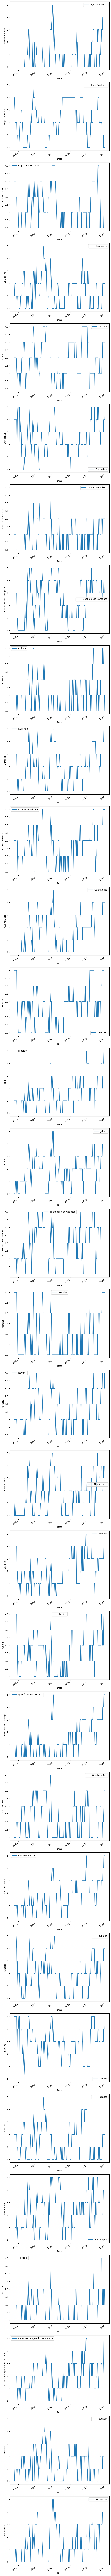

In [23]:
fig, axes = plt.subplots(nrows=len(df_new2.columns), ncols=1, figsize=(7, 5*len(df_new2.columns)))

for i, col in enumerate(df_new2.columns):
    df_new2[col].plot(ax=axes[i], legend=True)
    axes[i].set_ylabel(col)  
    axes[i].set_xlabel('Date')
    
plt.tight_layout()

plt.show()

To observe the recent trends over the past 2 years, we will graph the last 49 records

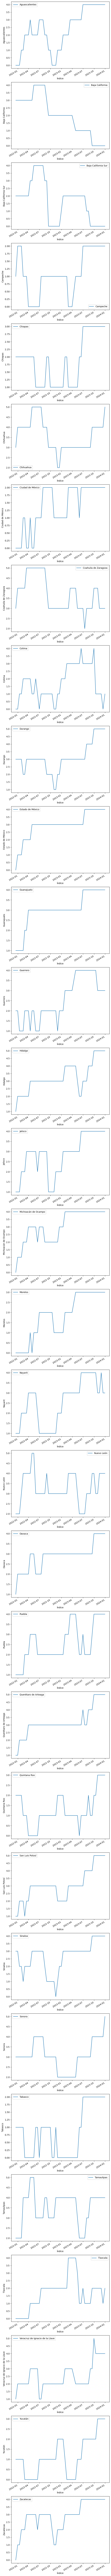

In [24]:
ultimas_20_filas = df_new2.tail(49)

fig, axes = plt.subplots(nrows=len(df_new2.columns), ncols=1, figsize=(7, 5*len(df_new2.columns)))


for i, col in enumerate(df_new2.columns):
    ultimas_20_filas[col].plot(ax=axes[i], legend=True)
    axes[i].set_ylabel(col)  
    axes[i].set_xlabel('Índice')  


plt.tight_layout()

plt.show()

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.ticker as plticker

In [26]:
df_new2.columns

Index(['Aguascalientes', 'Baja California', 'Baja California Sur', 'Campeche',
       'Chiapas', 'Chihuahua', 'Ciudad de México', 'Coahuila de Zaragoza',
       'Colima', 'Durango', 'Estado de México', 'Guanajuato', 'Guerrero',
       'Hidalgo', 'Jalisco', 'Michoacán de Ocampo', 'Morelos', 'Nayarit',
       'Nuevo León', 'Oaxaca', 'Puebla', 'Querétaro de Arteaga',
       'Quintana Roo', 'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco',
       'Tamaulipas', 'Tlaxcala', 'Veracruz de Ignacio de la Llave', 'Yucatán',
       'Zacatecas'],
      dtype='object', name='ENTIDAD')

In [27]:
df_new2.describe()

ENTIDAD  Aguascalientes  Baja California  Baja California Sur    Campeche  \
count        370.000000       370.000000           370.000000  370.000000   
mean           0.854054         2.321622             1.159459    1.332432   
std            1.223216         1.380003             1.191196    1.074603   
min            0.000000         0.000000             0.000000    0.000000   
25%            0.000000         1.000000             0.000000    0.000000   
50%            0.000000         2.000000             1.000000    1.000000   
75%            2.000000         4.000000             2.000000    2.000000   
max            5.000000         5.000000             4.000000    5.000000   

ENTIDAD     Chiapas   Chihuahua  Ciudad de México  Coahuila de Zaragoza  \
count    370.000000  370.000000        370.000000            370.000000   
mean       1.829730    2.548649          0.802703              2.437838   
std        1.249686    1.359125          0.840372              1.555714   
min        0.000000    0.000000          0.000000              0.000000   
25%        1.000000    1.250000          0.000000              1.000000   
50%        2.000000    2.000000          1.000000              3.000000   
75%        3.000000    3.000000          1.000000              4.000000   
max        4.000000    5.000000          4.000000              5.000000   

ENTIDAD      Colima     Durango  ...  Quintana Roo  San Luis Potosí  \
count    370.000000  370.000000  ...    370.000000       370.000000   
mean       0.981081    2.045946  ...      1.167568         1.945946   
std        1.047474    1.355726  ...      0.987196         1.254714   
min        0.000000    0.000000  ...      0.000000         0.000000   
25%        0.000000    1.000000  ...      0.000000         1.000000   
50%        1.000000    2.000000  ...      1.000000         2.000000   
75%        2.000000    3.000000  ...      2.000000         3.000000   
max        4.000000    5.000000  ...      4.000000         5.000000   

ENTIDAD     Sinaloa      Sonora     Tabasco  Tamaulipas    Tlaxcala  \
count    370.000000  370.000000  370.000000  370.000000  370.000000   
mean       2.000000    2.835135    1.389189    2.383784    0.810811   
std        1.333333    1.188179    1.287796    1.428990    0.853427   
min        0.000000    0.000000    0.000000    0.000000    0.000000   
25%        1.000000    2.000000    0.000000    1.000000    0.000000   
50%        2.000000    3.000000    1.000000    2.000000    1.000000   
75%        3.000000    4.000000    2.000000    4.000000    1.000000   
max        5.000000    5.000000    5.000000    5.000000    4.000000   

ENTIDAD  Veracruz de Ignacio de la Llave     Yucatán   Zacatecas  
count                         370.000000  370.000000  370.000000  
mean                            2.121622    1.297297    1.597297  
std                             1.147080    1.078614    1.320053  
min                             0.000000    0.000000    0.000000  
25%                             1.000000    0.000000    0.000000  
50%                             2.000000    1.000000    1.000000  
75%                             3.000000    2.000000    3.000000  
max                             5.000000    5.000000    5.000000  

[8 rows x 32 columns]

In [28]:
high= df_new2.describe().loc['mean'] >= 2
results = df_new2.describe().loc[:, high]
print(results)

ENTIDAD  Baja California   Chihuahua  Coahuila de Zaragoza     Durango  \
count         370.000000  370.000000            370.000000  370.000000   
mean            2.321622    2.548649              2.437838    2.045946   
std             1.380003    1.359125              1.555714    1.355726   
min             0.000000    0.000000              0.000000    0.000000   
25%             1.000000    1.250000              1.000000    1.000000   
50%             2.000000    2.000000              3.000000    2.000000   
75%             4.000000    3.000000              4.000000    3.000000   
max             5.000000    5.000000              5.000000    5.000000   

ENTIDAD     Jalisco  Michoacán de Ocampo      Oaxaca     Sinaloa      Sonora  \
count    370.000000           370.000000  370.000000  370.000000  370.000000   
mean       2.016216             2.094595    2.227027    2.000000    2.835135   
std        1.161607             1.163689    1.224114    1.333333    1.188179   
min        0.

In [29]:
df_new2.mean().mean()

1.7191722972972974

We observe that nearly all states exhibit maximum values of 5,which is the highest level of drought.
The country's average is 0.54, indicating that there are states with minimal drought occurrences. Conversely, states such as Sinaloa and Sonora exhibit the highest levels, with an average of 2.


In [30]:
orig_df = df_new2.copy()

We have our data prepared to apply the model for forecasting. For this project, we will utilize $ARIMA$, as it is a statistical forecasting model.

"This model comprises three components. The autoregressive element (AR) relates the current value to past (lagged) values. The moving average element (MA) assumes that the regression error is a linear combination of past forecast errors. Finally, the integrated component (I) indicates that the data values have been replaced with the difference between their values and the previous ones" (Amat Rodrigo, J. and Escobar Ortiz, J. 2023)

In the model, the parameters p,d y q, are utilized, each representing a component:

* p for the autoregressive element
* d number of differencing that have been performed
* q for the moving average element 

It is not necessary to use all three components, we can have combinations where one or two components are 0, meaning they are not utilized.

The next step in the process will be to determine these parameters for the series.

####  Stationarity (I)
We need our data to be stationary to ensure that the forecasts are more reliable. 

Therefore, we will conduct two tests for each column: the KPSS Test and the ADF Test. Both tests will compare the p-value against the alpha level (0.05) to determine whether the data series is stationary or not.

If:

p-value < $\alpha$ (0.05)

Kpss test = the series is non-stationary and thus needs to be differenced.

ADF test = the series is stationary.

If the ADF indicates stationarity and the KPSS indicates non-stationarity, we might be in a situation of "difference stationarity." This means we need to apply differencing to make the series stationary.

The purpose of differencing is to make the time series stationary.

We need to difference the series until it becomes stationary, but always seeking the minimum differencing; otherwise, the series could be over-differenced which it will affect the model parameters.




State: Aguascalientes

Test stationarity for original series
-------------------------------------
ADF Statistic: -3.807561768436704, p-value: 0.0028308888694204984
KPSS Statistic: 0.6781201895821427, p-value: 0.015534528219805208

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -20.122050860415143, p-value: 0.0
KPSS Statistic: 0.031450000181236844, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Baja California

Test stationarity for original series
-------------------------------------
ADF Statistic: -2.792131674225192, p-value: 0.0594065221171872
KPSS Statistic: 0.27239980523599167, p-value: 0.1

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -9.892483217777201, p-value: 3.5278343899854815e-17
KPSS Statistic: 0.050273826277030184, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Baja California Sur

Test stationarity for original series
-------------------------------------
ADF Statistic: -4.450873984325852, p-value: 0.00024098663532160864
KPSS Statistic: 0.24324444211575982, p-value: 0.1

It is stationary.


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])




State: Campeche

Test stationarity for original series
-------------------------------------
ADF Statistic: -5.651722331441935, p-value: 9.825767300509999e-07
KPSS Statistic: 0.10976716834745388, p-value: 0.1

It is stationary.


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])




State: Chiapas

Test stationarity for original series
-------------------------------------
ADF Statistic: -4.011163249766334, p-value: 0.0013531721131395242
KPSS Statistic: 0.25381514563944885, p-value: 0.1

It is stationary.


State: Chihuahua

Test stationarity for original series
-------------------------------------


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])


ADF Statistic: -2.7507447170273176, p-value: 0.06566124919353596
KPSS Statistic: 0.4060323571118696, p-value: 0.07455501848626311

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -6.7215412465105935, p-value: 3.4729870957858423e-09
KPSS Statistic: 0.07505988246602732, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Ciudad de México

Test stationarity for original series
-------------------------------------
ADF Statistic: -6.404719859722282, p-value: 1.956086701321731e-08
KPSS Statistic: 0.15494999586703137, p-value: 0.1

It is stationary.


State: Coahuila de Zaragoza

Test stationarity for original series
-------------------------------------


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])


ADF Statistic: -3.5377874355293724, p-value: 0.007068039264445461
KPSS Statistic: 0.4749671917477875, p-value: 0.047304686543291105

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -6.5091143659903565, p-value: 1.1118348101415274e-08
KPSS Statistic: 0.021383807588075884, p-value: 0.1


The serie is differenced (order 1)


State: Colima

Test stationarity for original series
-------------------------------------
ADF Statistic: -6.275331300942066, p-value: 3.9132682689371444e-08
KPSS Statistic: 0.40689098573146765, p-value: 0.07418491994333291

It is stationary.


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Durango

Test stationarity for original series
-------------------------------------
ADF Statistic: -2.9206146525438097, p-value: 0.043002774802981904
KPSS Statistic: 0.690467398067567, p-value: 0.014412054721130274

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -5.996715170115793, p-value: 1.6947718492148493e-07
KPSS Statistic: 0.049371019212144776, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Estado de México

Test stationarity for original series
-------------------------------------
ADF Statistic: -4.676979028694096, p-value: 9.2943961016205e-05
KPSS Statistic: 1.1809514582730127, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -15.994676745216442, p-value: 6.612118493007541e-29
KPSS Statistic: 0.05158110448730743, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Guanajuato

Test stationarity for original series
-------------------------------------
ADF Statistic: -3.0920852277152306, p-value: 0.02714448876706957
KPSS Statistic: 0.9639649527414869, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -7.6643033870516, p-value: 1.6568104093115384e-11
KPSS Statistic: 0.016646635895702096, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Guerrero

Test stationarity for original series
-------------------------------------
ADF Statistic: -4.433341516283181, p-value: 0.0002589984624122011
KPSS Statistic: 1.1637692152631025, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -7.552254993166594, p-value: 3.16610199842055e-11
KPSS Statistic: 0.050747077469345946, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Hidalgo

Test stationarity for original series
-------------------------------------
ADF Statistic: -3.2044005875900514, p-value: 0.019731364816311436
KPSS Statistic: 1.8861170373710916, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -7.649070375268875, p-value: 1.809567426004741e-11
KPSS Statistic: 0.027094354808169716, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Jalisco

Test stationarity for original series
-------------------------------------
ADF Statistic: -4.759551502973458, p-value: 6.49507371520164e-05
KPSS Statistic: 0.5930551442655826, p-value: 0.023267714157674306

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -8.764153099842124, p-value: 2.625123119295457e-14
KPSS Statistic: 0.01809112852411991, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Michoacán de Ocampo

Test stationarity for original series
-------------------------------------
ADF Statistic: -3.4652696203999316, p-value: 0.008925149662861507
KPSS Statistic: 0.807318911129436, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -6.949328118795061, p-value: 9.784744180661885e-10
KPSS Statistic: 0.011585895088045509, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Morelos

Test stationarity for original series
-------------------------------------
ADF Statistic: -5.764518432312849, p-value: 5.57264209836272e-07
KPSS Statistic: 0.36326018373134933, p-value: 0.0929913001157977

It is stationary.


State: Nayarit

Test stationarity for original series
-------------------------------------


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])


ADF Statistic: -4.48689032767895, p-value: 0.0002076481234194239
KPSS Statistic: 0.27587003746217503, p-value: 0.1

It is stationary.


State: Nuevo León

Test stationarity for original series
-------------------------------------
ADF Statistic: -2.7255379352616944, p-value: 0.06972238331018774
KPSS Statistic: 0.755509274507455, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -7.576982295105623, p-value: 2.7450817848517025e-11
KPSS Statistic: 0.013939934957113638, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Oaxaca

Test stationarity for original series
-------------------------------------
ADF Statistic: -3.92932467825463, p-value: 0.0018293255446890553
KPSS Statistic: 1.2384022901999965, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -9.26446562523315, p-value: 1.3788604707827033e-15
KPSS Statistic: 0.044289585753000384, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Puebla

Test stationarity for original series
-------------------------------------
ADF Statistic: -2.503927965344646, p-value: 0.11452153127723053
KPSS Statistic: 0.8163594185754522, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -9.914614013536687, p-value: 3.103768649894871e-17
KPSS Statistic: 0.091341810854006, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib



State: Querétaro de Arteaga

Test stationarity for original series
-------------------------------------
ADF Statistic: -1.5817041843301265, p-value: 0.4927772516212584
KPSS Statistic: 2.025368951357976, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -8.24812873543649, p-value: 5.483136204297095e-13
KPSS Statistic: 0.0236253534117423, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Quintana Roo

Test stationarity for original series
-------------------------------------
ADF Statistic: -5.568303932006249, p-value: 1.4872655196526566e-06
KPSS Statistic: 0.0879526229891651, p-value: 0.1

It is stationary.


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])




State: San Luis Potosí

Test stationarity for original series
-------------------------------------
ADF Statistic: -3.3716129994591943, p-value: 0.011965496685950096
KPSS Statistic: 1.7896728468828618, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -7.6137085203324055, p-value: 2.2202948161911833e-11
KPSS Statistic: 0.03383817630924212, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())




State: Sinaloa

Test stationarity for original series
-------------------------------------
ADF Statistic: -4.705074148843005, p-value: 8.232506264610736e-05
KPSS Statistic: 0.26649258730835984, p-value: 0.1

It is stationary.


State: Sonora

Test stationarity for original series
-------------------------------------
ADF Statistic: -4.210217970334595, p-value: 0.0006331442594822575
KPSS Statistic: 0.14082318829010243, p-value: 0.1

It is stationary.


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value i



State: Tabasco

Test stationarity for original series
-------------------------------------
ADF Statistic: -4.62661622454716, p-value: 0.00011533888462289829
KPSS Statistic: 0.14668114192866638, p-value: 0.1

It is stationary.


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])




State: Tamaulipas

Test stationarity for original series
-------------------------------------
ADF Statistic: -4.8808130142065895, p-value: 3.80007841689957e-05
KPSS Statistic: 0.6967046349534993, p-value: 0.013845033186045515

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -7.649474285812208, p-value: 1.8053417847128903e-11
KPSS Statistic: 0.012696742577568212, p-value: 0.1


The serie is differenced (order 1)


State: Tlaxcala

Test stationarity for original series
-------------------------------------


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())


ADF Statistic: -5.164292724032649, p-value: 1.0394327122277285e-05
KPSS Statistic: 0.5780558786971473, p-value: 0.024631283754804792

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -10.097063519114254, p-value: 1.0838290779320792e-17
KPSS Statistic: 0.018909108148821782, p-value: 0.1


The serie is differenced (order 1)


State: Veracruz de Ignacio de la Llave

Test stationarity for original series
-------------------------------------


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())


ADF Statistic: -4.949321949415556, p-value: 2.7931942339331747e-05
KPSS Statistic: 1.0786906638145968, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -9.238713716412144, p-value: 1.6041097569451014e-15
KPSS Statistic: 0.01983999647648369, p-value: 0.1


The serie is differenced (order 1)


State: Yucatán

Test stationarity for original series
-------------------------------------


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])


ADF Statistic: -5.512229227259099, p-value: 1.960431230077941e-06
KPSS Statistic: 0.12989669828831746, p-value: 0.1

It is stationary.


State: Zacatecas

Test stationarity for original series
-------------------------------------
ADF Statistic: -3.756818732706381, p-value: 0.0033813362983931244
KPSS Statistic: 0.6475658590101576, p-value: 0.018312194635440215

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -22.46957959233008, p-value: 0.0
KPSS Statistic: 0.01988314092141013, p-value: 0.1


The serie is differenced (order 1)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\1246164885.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_new2[col].diff().dropna())


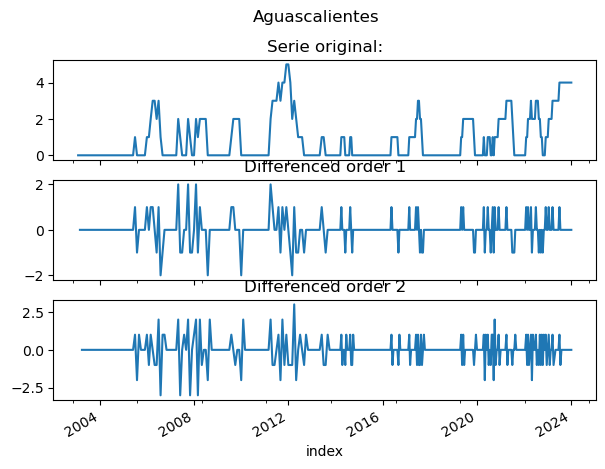

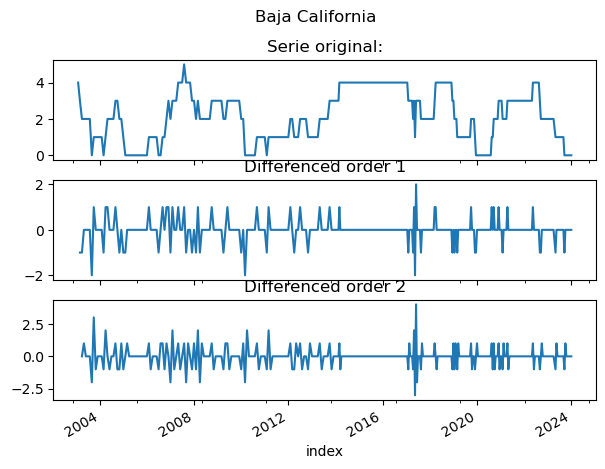

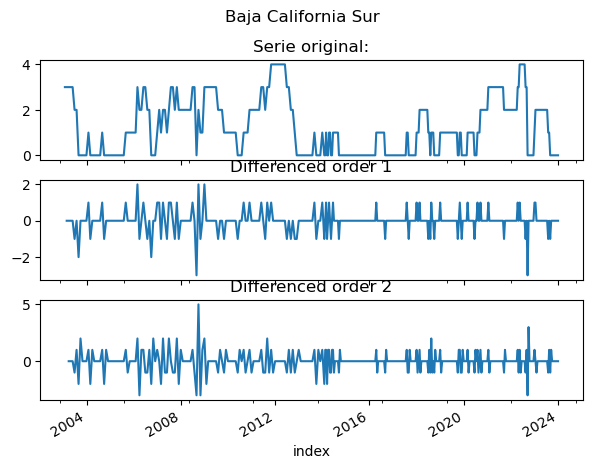

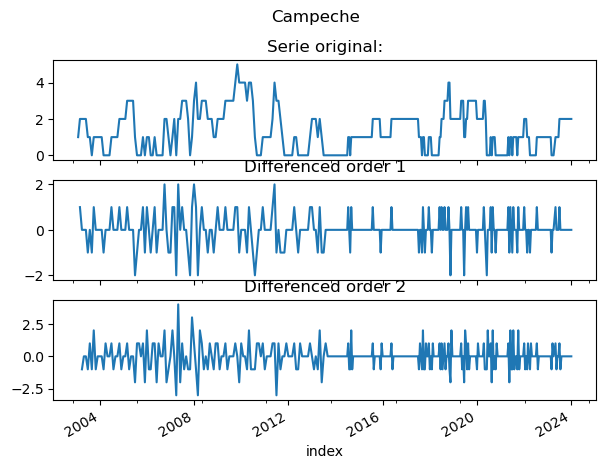

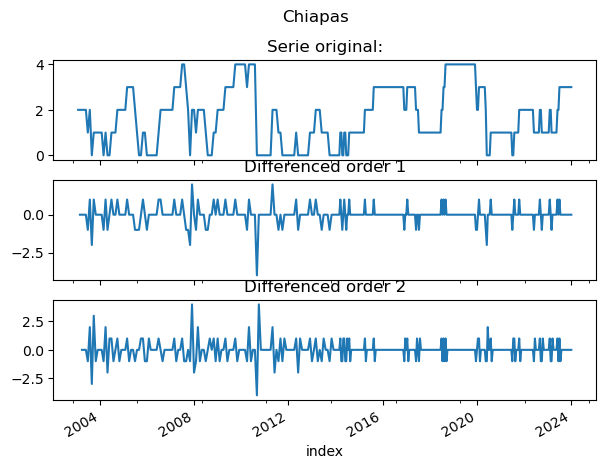

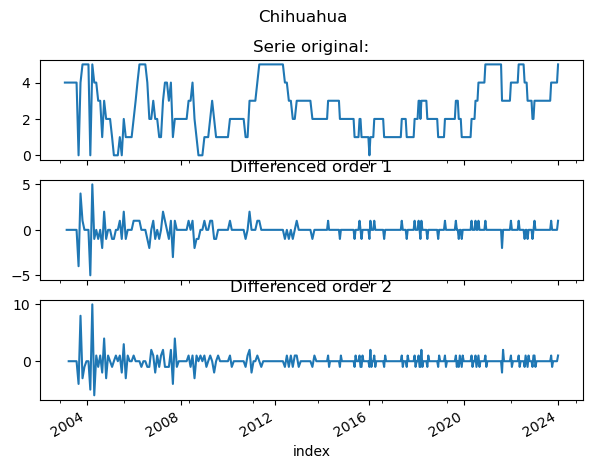

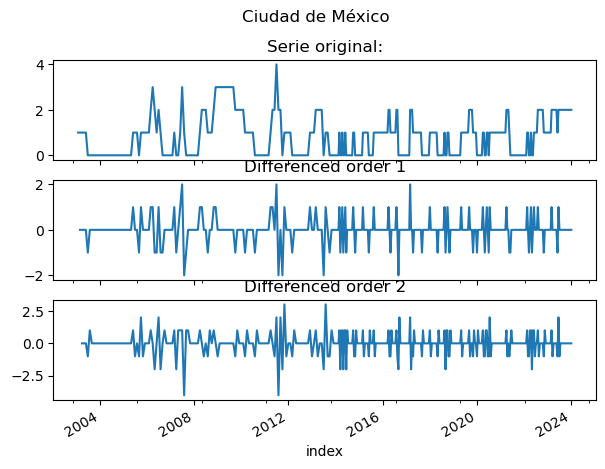

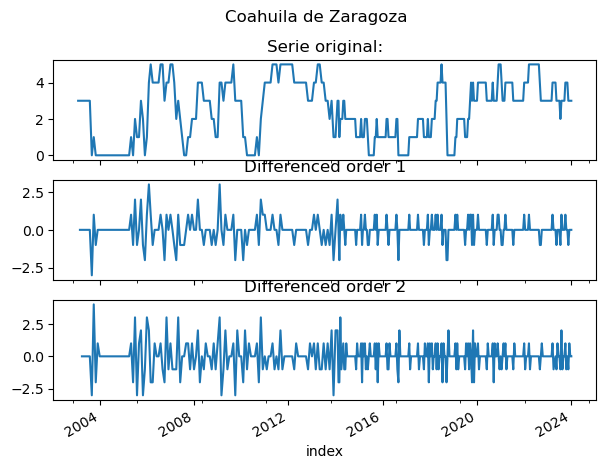

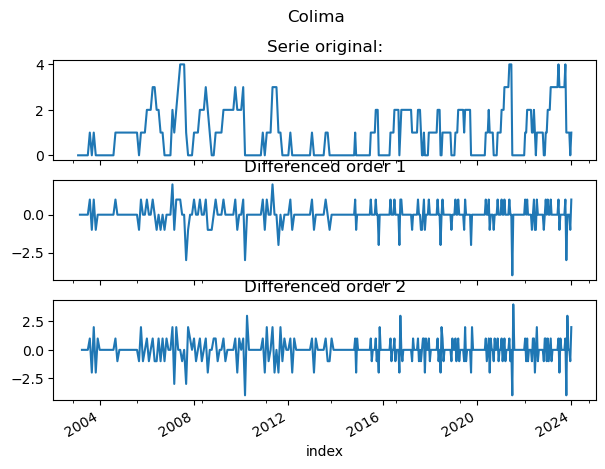

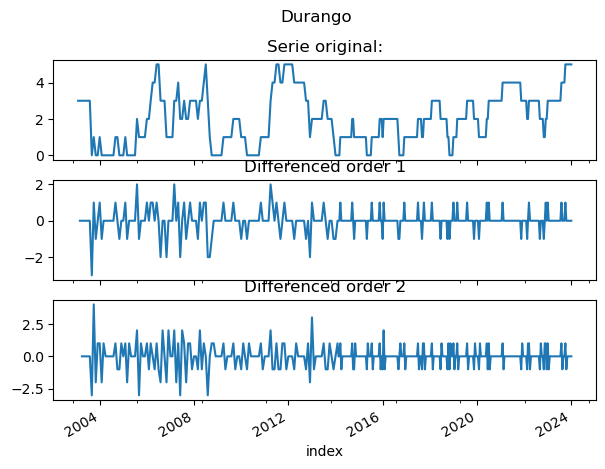

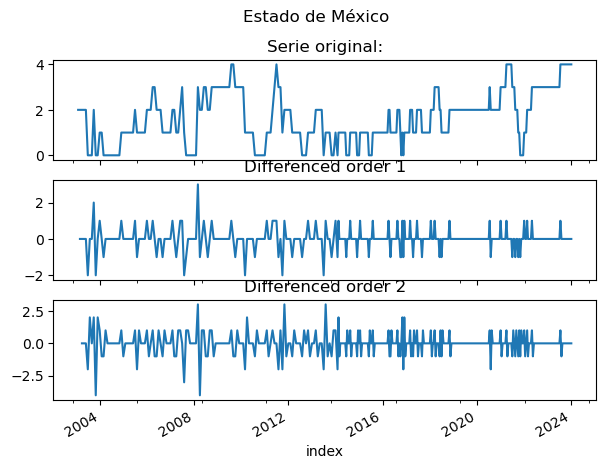

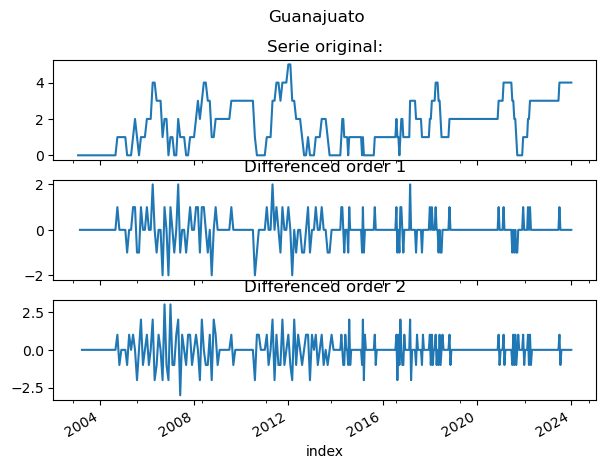

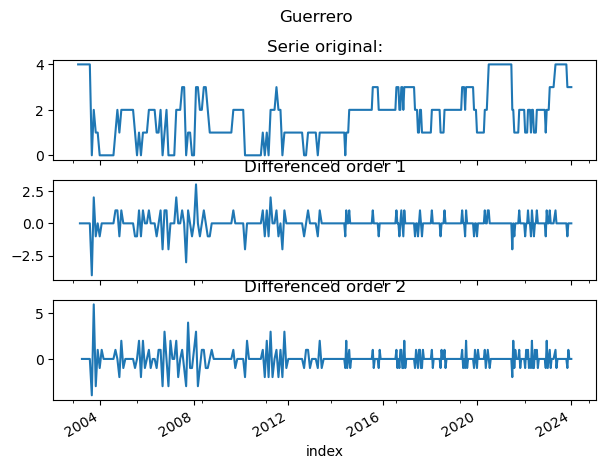

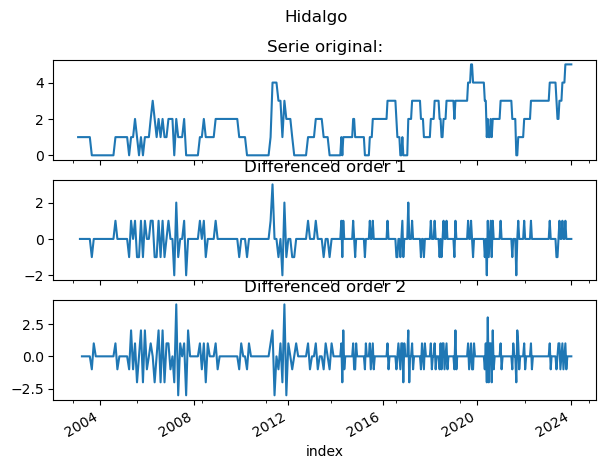

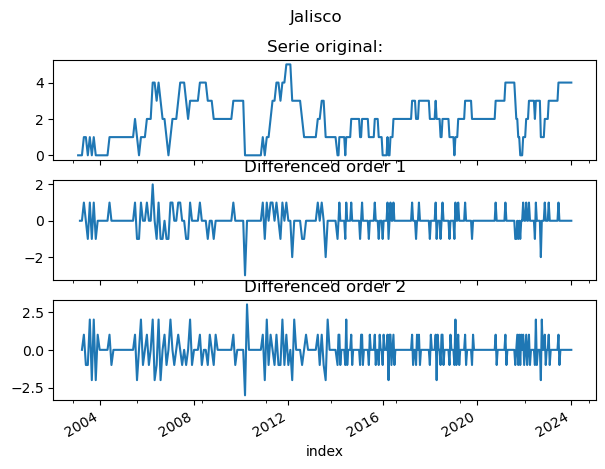

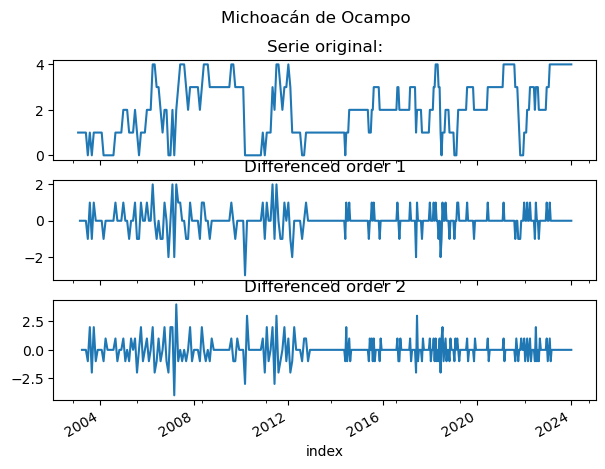

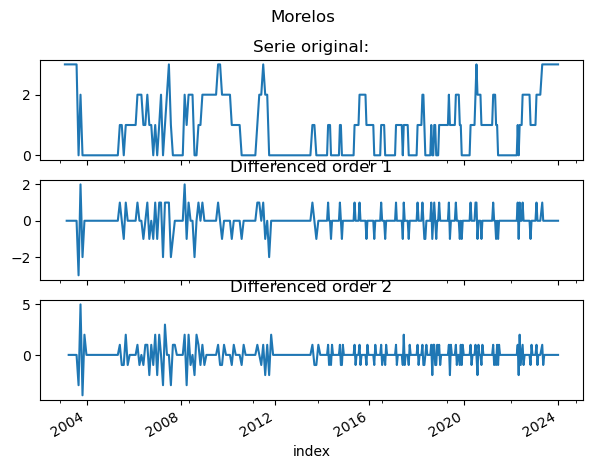

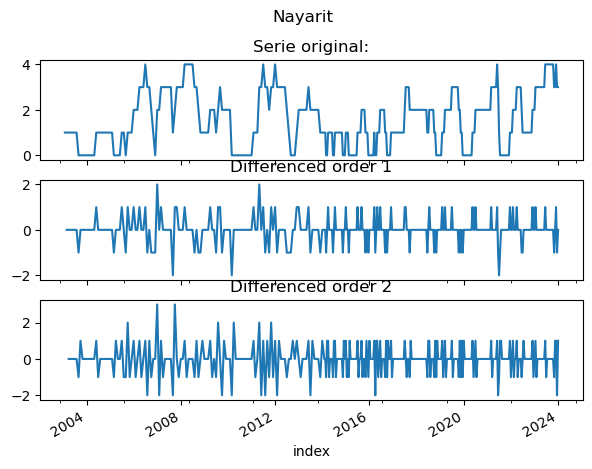

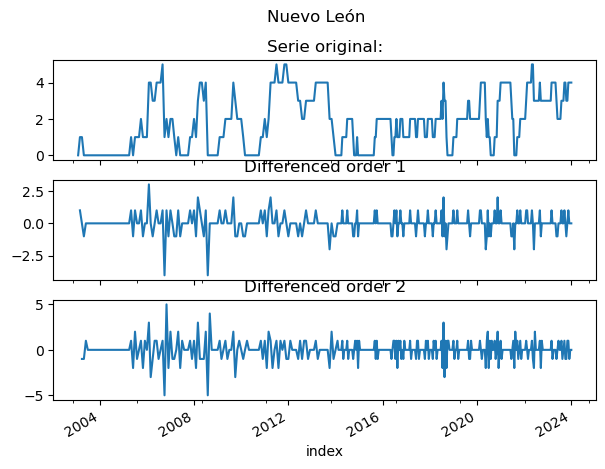

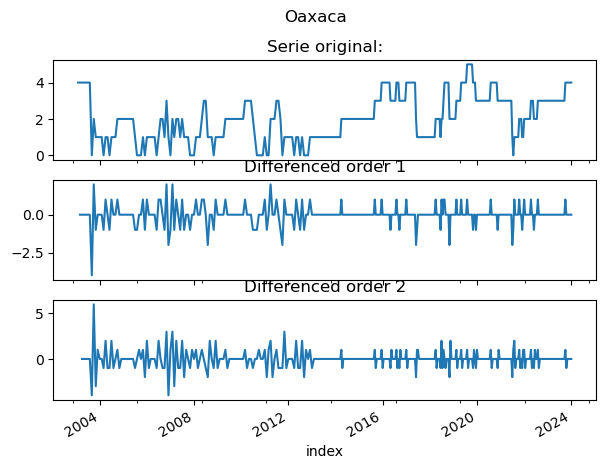

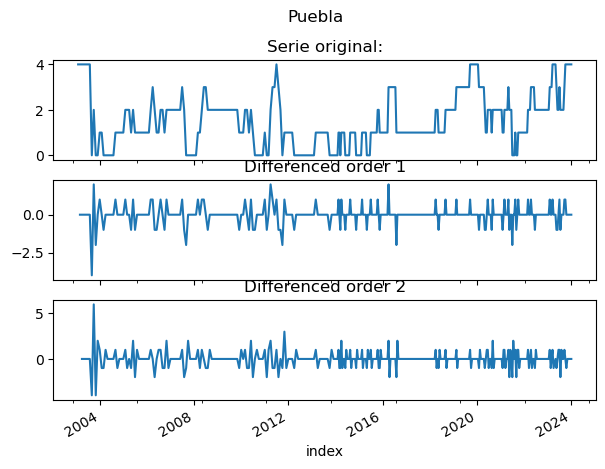

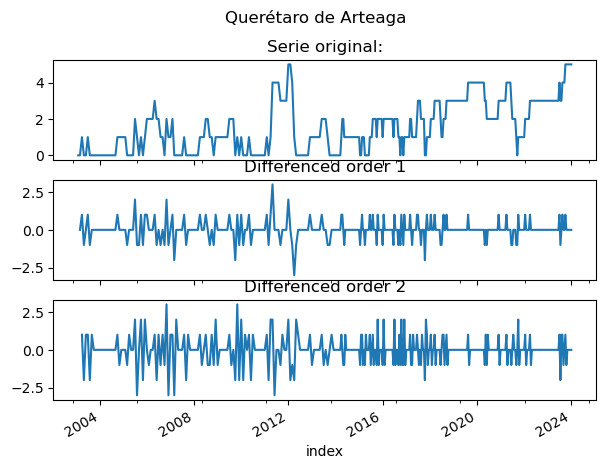

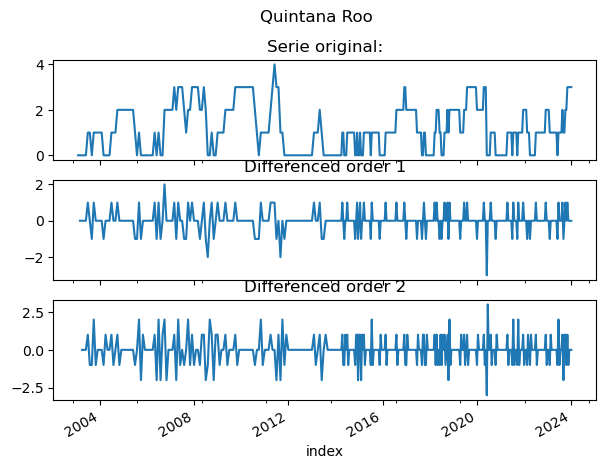

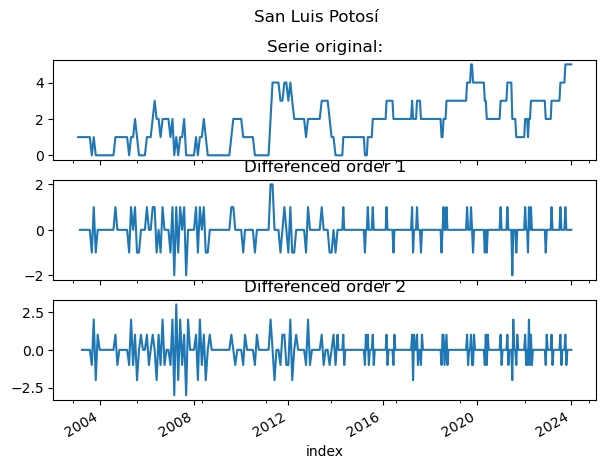

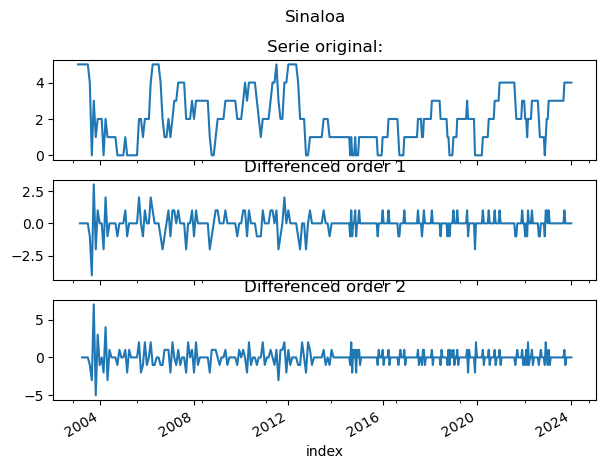

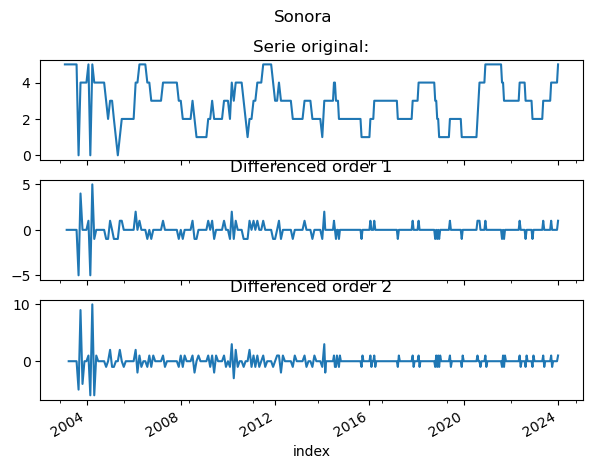

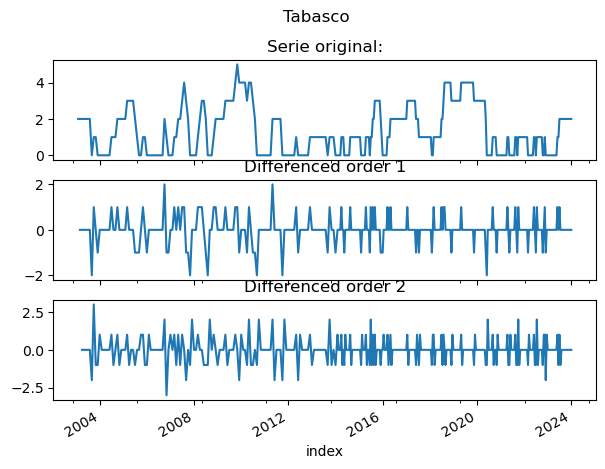

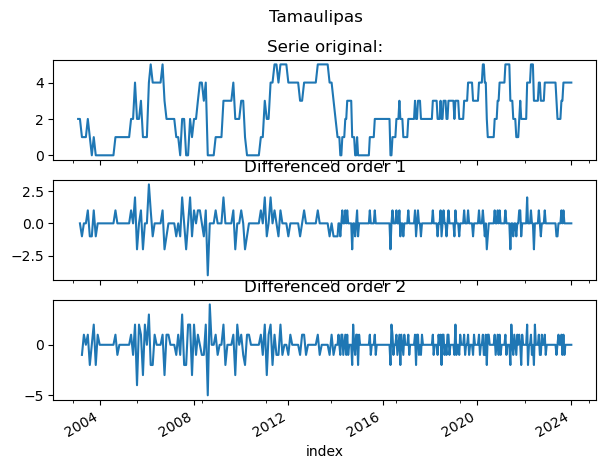

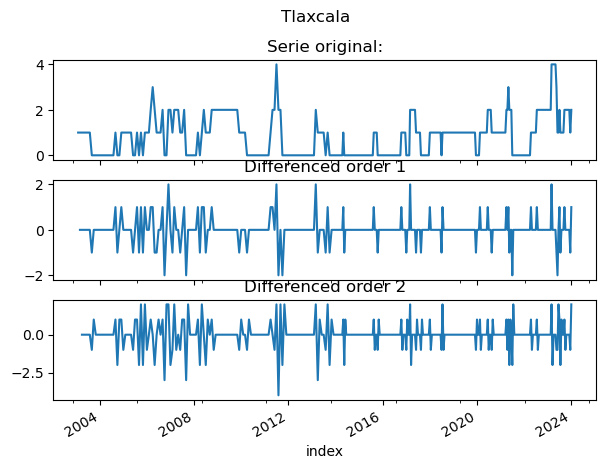

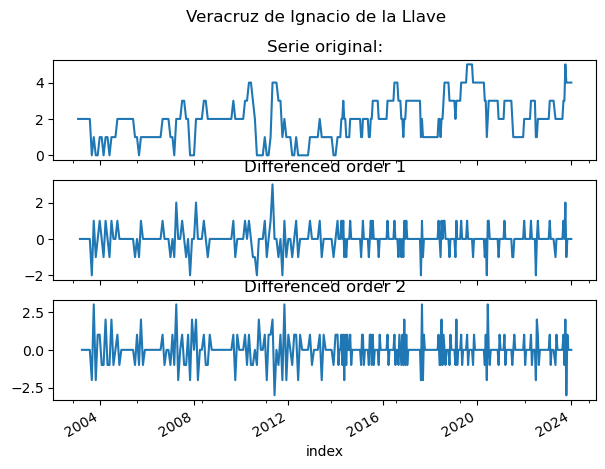

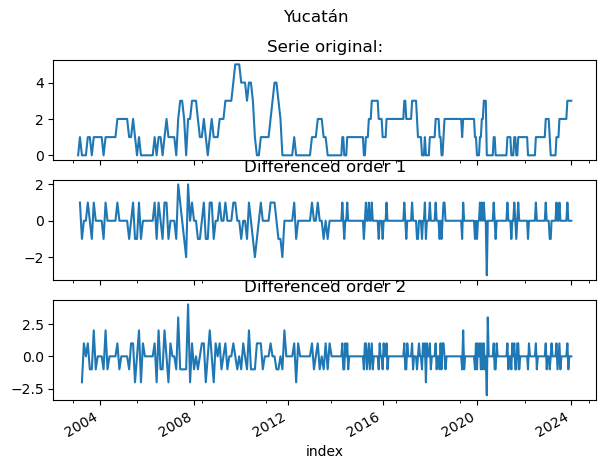

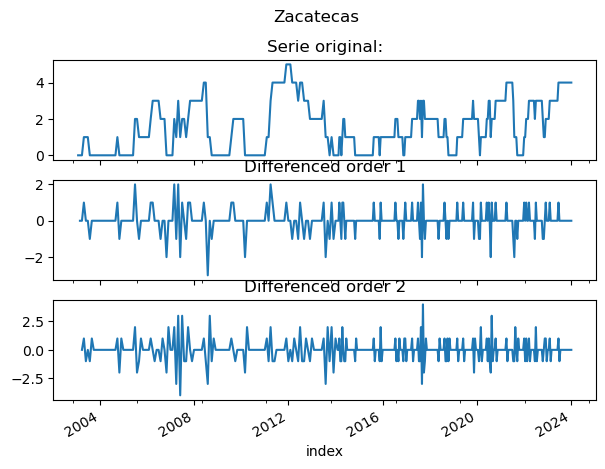

In [31]:
warnings.filterwarnings("default")
datos_diff_1 = {}
datos_diff_2 = {}
value_d= []
for i, col in enumerate(df_new2.columns):
    datos_diff_1[col] = df_new2[col].diff().dropna()
    datos_diff_2[col] = datos_diff_1[col].diff().dropna()
    print('\n')
    print("State:",df_new2.columns[i])
    print('\nTest stationarity for original series')
    print('-------------------------------------')
    adfuller_result = adfuller(df_new2[col])
    kpss_result= kpss(df_new2[col])
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
   
    adfuller_result = adfuller(df_new2[col])
    kpss_result= kpss(df_new2[col])
    
    if kpss_result[1] < 0.05 or adfuller_result[1] >0.05:
            
     print('\nTest stationarity for differenced series (order=1)')
     print('--------------------------------------------------')
     adfuller_result1 = adfuller(datos_diff_1[col])
     kpss_result = kpss(df_new2[col].diff().dropna())
     print(f'ADF Statistic: {adfuller_result1[0]}, p-value: {adfuller_result1[1]}')
     print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
             
     if kpss_result[1] < 0.05 or adfuller_result1[1] >0.05:
            print('\nTest stationarity for differenced series (order=2)')
            print('--------------------------------------------------')
            adfuller_result2 = adfuller(datos_diff_2[col])
            kpss_result = kpss(df_new2[col].diff().diff().dropna())
            print(f'ADF Statistic: {adfuller_result2[0]}, p-value: {adfuller_result2[1]}')
            print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
         
            df_new2[col]=datos_diff_2[col]
            print("The serie is differenced (order 2)")
            d=2
            value_d.append(d)
     else:
        df_new2[col]=datos_diff_1[col]
        print("\n\nThe serie is differenced (order 1)")
        d=1
        value_d.append(d)
    else:
        print("\nIt is stationary.")
        d=0
        value_d.append(d)
        
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
    fig.suptitle(df_new2.columns[i])
    orig_df[col].plot(ax=axs[0], title='\nSerie original:')
    datos_diff_1[col].plot(ax=axs[1], title='\nDifferenced order 1')
    datos_diff_2[col].plot(ax=axs[2], title='\nDifferenced order 2')

            

As we saw, if the series is stationary, it is not differenced and d=0

If the series is non-stationary, it is differenced twice, but we will take the first differencing if it passes both tests for stationarity, making d=1. If it needs another differencing, d=2. 

The d values for each feature will be stored in value_d, we will use this value for the model we are going to employ.

In [32]:
value_d

[1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1]

#### Autocorrelation Function (ACF) for MA

After having all our series stationary, we will plot the ACF to identify the value of q

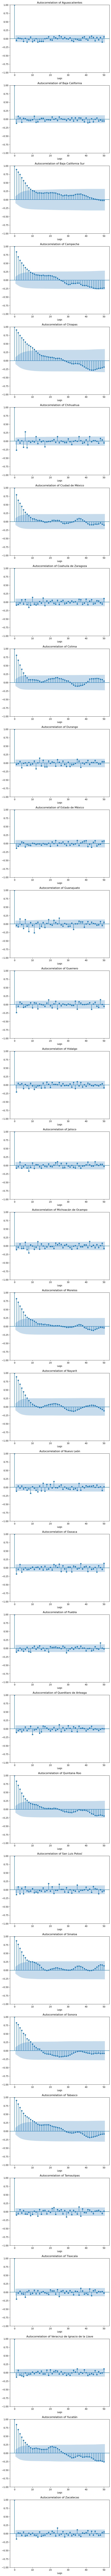

In [33]:
num_cols = len(df_new2.columns)
df_new2=df_new2.fillna(0)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(7, 5*num_cols))

for i, col in enumerate(df_new2.columns):
    plot_acf(df_new2[col], ax=axes[i], lags=50)
    axes[i].set_title(f'Autocorrelation of {col}')  
    axes[i].set_xlabel('Lags')

plt.tight_layout()
plt.show()

The ACF calculates the correlation between a time series and its lagged values. The lag at which the ACF falls provides an estimate of the value of q. 

We will assign q for each series conservatively.


In [34]:
value_q=[1,1,2,2,2,2,2,1,2,1,1,2,1,1,1,1,2,2,1,1,1,1,2,1,2,2,2,1,1,1,2,1]

#### Partial Autocorrelation Function (PACF) for AR
The PACF helps identify the value of p

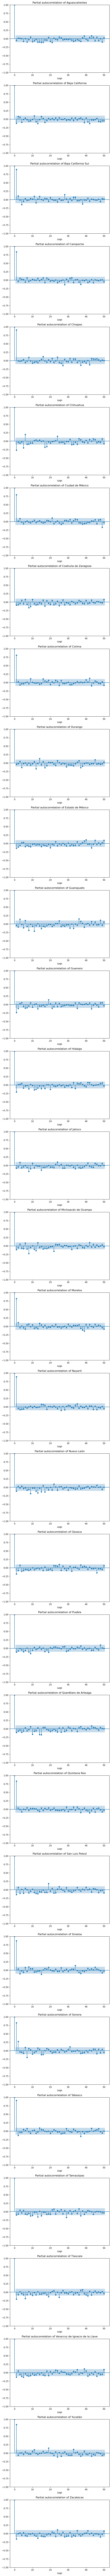

In [35]:
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(7, 5*num_cols))

# Iterar sobre las columnas y trazar la autocorrelación de cada una
for i, col in enumerate(df_new2.columns):
    plot_pacf(df_new2[col], ax=axes[i],lags=50)
    axes[i].set_title(f'Partial autocorrelation of {col}')  # Establecer el título de la gráfica
    axes[i].set_xlabel('Lags')
# Ajustar la disposición de las subgráficas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

The PACF measures the correlation between a lagged value and the current value of the time series, taking into account the effect of intermediate lags. The lag at which the PACF cuts off provides an indication of the value of p

In [36]:
value_p=[1,1,2,2,2,2,2,1,2,1,1,1,2,2,1,1,2,2,1,1,1,1,2,1,2,3,2,1,1,1,2,1] 
len(value_p)

32

In [37]:
names=df_new2.columns
valuesmodel = pd.DataFrame()

In [38]:
valuesmodel = pd.concat([valuesmodel, pd.DataFrame([value_d])], ignore_index=True)
valuesmodel = pd.concat([valuesmodel, pd.DataFrame([value_q])], ignore_index=True)
valuesmodel = pd.concat([valuesmodel, pd.DataFrame([value_p])], ignore_index=True)

Creating a new dataframe to store the model parameters for each feature

In [39]:
valuesmodel.columns=names
new_index=['d', 'q', 'p']
valuesmodel = valuesmodel.set_index(pd.Index(new_index))
valuesmodel

ENTIDAD  Aguascalientes  Baja California  Baja California Sur  Campeche  \
d                     1                1                    0         0   
q                     1                1                    2         2   
p                     1                1                    2         2   

ENTIDAD  Chiapas  Chihuahua  Ciudad de México  Coahuila de Zaragoza  Colima  \
d              0          1                 0                     1       0   
q              2          2                 2                     1       2   
p              2          2                 2                     1       2   

ENTIDAD  Durango  ...  Quintana Roo  San Luis Potosí  Sinaloa  Sonora  \
d              1  ...             0                1        0       0   
q              1  ...             2                1        2       2   
p              1  ...             2                1        2       3   

ENTIDAD  Tabasco  Tamaulipas  Tlaxcala  Veracruz de Ignacio de la Llave  \
d              0           1         1                                1   
q              2           1         1                                1   
p              2           1         1                                1   

ENTIDAD  Yucatán  Zacatecas  
d              0          1  
q              2          1  
p              2          1  

[3 rows x 32 columns]

In [40]:
from statsmodels.tsa.arima.model import ARIMA

The next step is to apply the model. For this, we will randomly select 3 states, one from each region of Mexico, which are divided as follows:

1. Northern Region: Baja California, Baja California Sur, $Sonora$, Chihuahua, Coahuila, Nuevo León, Tamaulipas
2. Central Region: Durango, Zacatecas, San Luis Potosí, Aguascalientes, Nayarit, Guanajuato, Querétaro, Michoacán, Estado de México, Hidalgo, Mexico City, $Morelos$, Tlaxcala, Puebla
3. Pacific Region: Sinaloa, $Colima$, Jalisco, Guerrero
4. Southern Region:Oaxaca, Chiapas, Tabasco, Campeche, Yucatan, $Quintana Roo$, Veracruz
   
These regions represent Mexico's geographical, climatic, economic, and cultural diversity, and each has its own unique characteristics and attractions.

## SONORA (Northern Region)

In [41]:
print(valuesmodel["Sonora"])

d    0
q    2
p    3
Name: Sonora, dtype: int64


We will utilize ARIMA with the values obtained from the analyses above

In [42]:
#arima ( p d q )
model = ARIMA(df_new2["Sonora"], order=(3,0,2)) 
model_fit = model.fit()
print(model_fit.summary())

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Sonora   No. Observations:                  370
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -348.947
Date:                Sat, 18 May 2024   AIC                            711.895
Time:                        21:39:23   BIC                            739.289
Sample:                             0   HQIC                           722.776
                                - 370                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9179      0.269     10.862      0.000       2.391       3.444
ar.L1          0.3772      0.101      3.747      0.000       0.180       0.575
ar.L2         -0.2458      0.076     -3.248      0.0

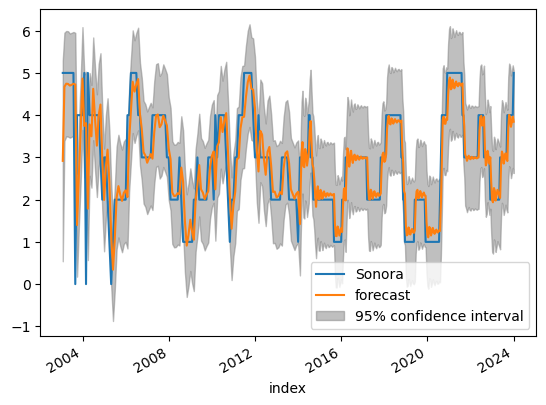

In [43]:
from statsmodels.graphics.tsaplots import plot_predict
fig, ax = plt.subplots()  
ax = df_new2["Sonora"].plot(ax=ax)
fig= plot_predict(model_fit, ax=ax, dynamic=False,)
plt.show()

#### Out-of-Time Cross validation
To do out-of-time cross-validation, we will create the training and testing dataset by splitting the time series into 2 contiguous segments, 85% and 15% respectively.

We will compare our forecast against the actual values.

In [44]:
Sonora=df_new2["Sonora"]
Sonora

index
2003-01-31    5
2003-02-28    5
2003-03-31    5
2003-04-30    5
2003-05-31    5
             ..
2023-10-31    4
2023-11-15    4
2023-11-30    4
2023-12-15    4
2023-12-31    5
Name: Sonora, Length: 370, dtype: int32

In [45]:
p_train1 = 0.85 ### 15% for test data

train1 = Sonora[:int(len(Sonora) * p_train1)]
test1 = Sonora[int(len(Sonora) * p_train1):]
train1

index
2003-01-31    5
2003-02-28    5
2003-03-31    5
2003-04-30    5
2003-05-31    5
             ..
2021-06-15    5
2021-06-30    5
2021-07-15    5
2021-07-31    5
2021-08-15    4
Name: Sonora, Length: 314, dtype: int32

Train dates : 2003-01-31 00:00:00 --- 2021-08-15 00:00:00  (n=314)
Test dates  : 2021-08-15 00:00:00 --- 2023-12-31 00:00:00  (n=57)


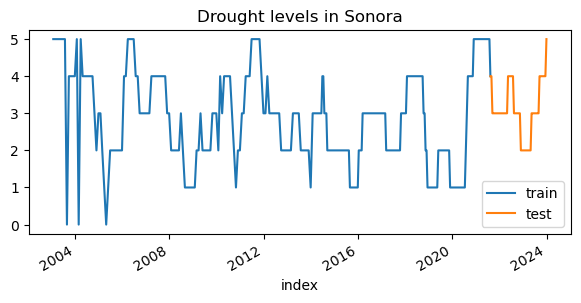

In [46]:

fin_train = '2021-08-15 00:00:00'
print(
    f"Train dates : {Sonora.index.min()} --- {Sonora.loc[:fin_train].index.max()}  "
    f"(n={len(Sonora.loc[:fin_train])})"
)
print(
    f"Test dates  : {Sonora.loc[fin_train:].index.min()} --- {Sonora.loc[:].index.max()}  "
    f"(n={len(Sonora.loc[fin_train:])})"
)
data_train = Sonora.loc[:fin_train]
data_test  = Sonora.loc[fin_train:]


fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Drought levels in Sonora')
ax.legend();

We will apply the ARIMA model again using only the trainning data

In [47]:
modelS = ARIMA(data_train, order=(3,0,2))  
fitted = modelS.fit()  
print(fitted.summary())

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Sonora   No. Observations:                  314
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -312.743
Date:                Sat, 18 May 2024   AIC                            639.486
Time:                        21:39:24   BIC                            665.732
Sample:                             0   HQIC                           649.974
                                - 314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8648      0.289      9.898      0.000       2.297       3.432
ar.L1          0.3839      0.096      4.007      0.000       0.196       0.572
ar.L2         -0.3002      0.072     -4.144      0.0

In [48]:
data_test.index
datdata = pd.Series(data_test.index)

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


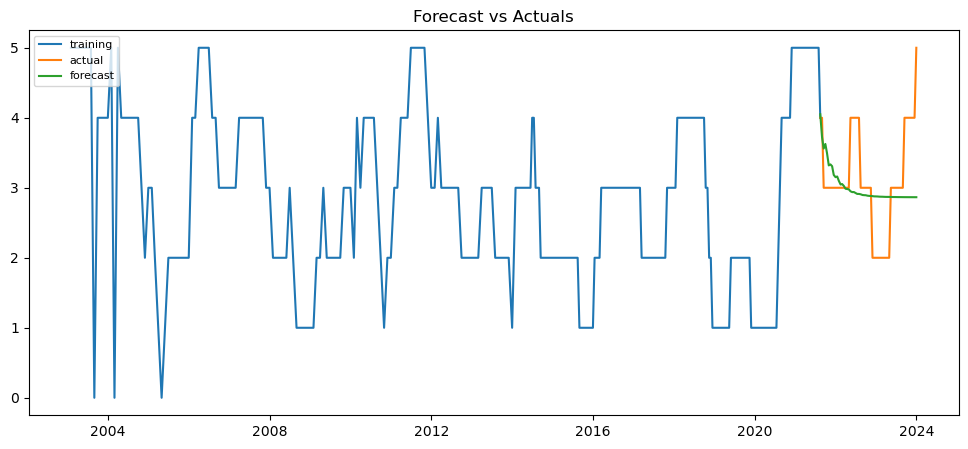

In [49]:
fc = fitted.forecast(57, alpha=0.05)  # 95% conf
conf= fitted.forecast(57, alpha=0.05) 
# Make as pandas series
fc_series = pd.Series(fc.values, index=datdata)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train, label='training')
plt.plot(data_test, label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Metrics:
I will use the following metrics to assess the accuracy of the forecasts:

In [50]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    me = np.mean(forecast - actual)             
    mae = np.mean(np.abs(forecast - actual))    
    mpe = np.mean((forecast - actual)/actual)   
    rmse = np.mean((forecast - actual)**2)**.5  
    corr = np.corrcoef(forecast, actual)[0,1]   
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             
                         # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc.values, data_test.values)

{'mape': 0.1791524415519957,
 'me': -0.11386948487869052,
 'mae': 0.5402134212418244,
 'mpe': 0.013912914648951577,
 'rmse': 0.7222543523808019,
 'corr': 0.13451354269182872,
 'minmax': 0.1535632065257534}

An approximate MAPE of 17.91% suggests the model is approximately 82.1% accurate in predicting the next 57 observations. However, upon inspection of the plot, the forecast does not closely resemble the actual data.

#### Auto Arima 

We will use stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [51]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(Sonora, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=729.511, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1882.881, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=767.259, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1526.675, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=727.518, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=729.537, Time=0.08 sec


C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=725.459, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=727.804, Time=0.10 sec


C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

 ARIMA(3,0,2)(0,0,0)[0]             : AIC=730.864, Time=0.24 sec


C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=727.062, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=729.334, Time=0.11 sec


C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

 ARIMA(3,0,3)(0,0,0)[0]             : AIC=722.716, Time=0.38 sec


C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=708.966, Time=0.53 sec


C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=712.488, Time=0.43 sec


C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=711.895, Time=0.43 sec


C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\dnisg\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=714.374, Time=0.25 sec

Best model:  ARIMA(3,0,3)(0,0,0)[0] intercept
Total fit time: 3.457 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  370
Model:               SARIMAX(3, 0, 3)   Log Likelihood                -346.483
Date:                Sat, 18 May 2024   AIC                            708.966
Time:                        21:39:28   BIC                            740.274
Sample:                             0   HQIC                           721.402
                                - 370                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5816      0.242      2.407      0.016       0.108  

The model summary shows a lot of information about the fitting process, we will use two metrics to compare the results of the two models with the parameter changes we made:

* Log-Likelihood : It is a measure that explains how well the model fits the data. If it is negative, it indicates poor fit, and if it is close to 0, it indicates a better fit.
* AIC: It is a goodness-of-fit metric. The lower it is, the better the model.

The AIC has reduced to 708 from 711 and the Log-likelihood  improved from -348.947 to -346.483, however it is still a poor performance as the score remains negative

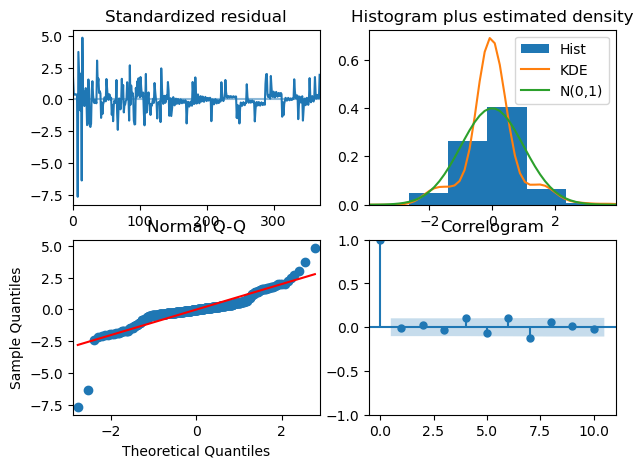

In [52]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

We can observe in our plot at the top left that the residuals exhibit a wide spread initially and then gradually approach zero. However, they do not behave as expected, as they are not fluctuating around zero.

In the bottom left plot, most of the data points fall on the red line, but we can see that towards the tails, the values deviate, indicating a greater difference at the beginning and end.

Finally, we observe that there is no discernible pattern in the ACF plot

In [53]:
n_periods = 26 ## 26 weeks to 
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### Results:
Using the latest model to predict the drought levels in Sonora for the 26 bi-weekly periods to cover all of 2024

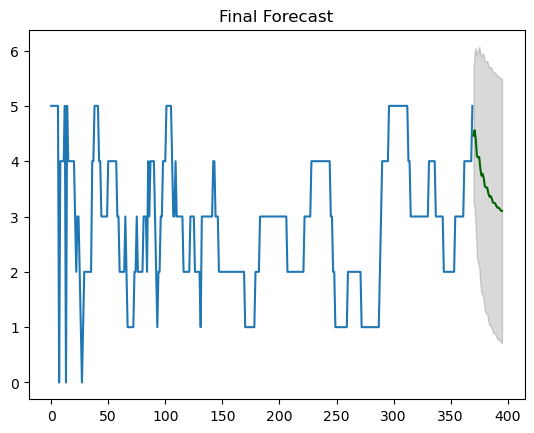

In [54]:
index_of_fc = np.arange(len(Sonora), len(Sonora)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc.values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(Sonora.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.show()

In [55]:
f_Sonora=fc_series
f_Sonora

370    4.462601
371    4.559458
372    4.397110
373    4.086813
374    4.068156
375    4.075842
376    3.863401
377    3.737566
378    3.770790
379    3.688775
380    3.541235
381    3.525175
382    3.521654
383    3.420081
384    3.357875
385    3.367507
386    3.325971
387    3.255476
388    3.244305
389    3.239129
390    3.190323
391    3.159447
392    3.161049
393    3.139966
394    3.106116
395    3.099059
dtype: float64

These are the results for 24 bi-weekly periods.
We observe that we did not obtain good forecasts, as the values start high and then decrease. In contrast, the current drought levels fluctuate across all 4 levels throughout the year.

## MORELOS (Central Region)

We will follow the same steps as above for this new dataset

In [56]:
print(valuesmodel["Morelos"])

d    0
q    2
p    2
Name: Morelos, dtype: int64


In [57]:
from statsmodels.tsa.arima.model import ARIMA
# arima (p d q )
model_Mor = ARIMA(df_new2["Morelos"], order=(2,0,2))
model_fit_Mor = model_Mor.fit()
print(model_fit_Mor.summary())

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Morelos   No. Observations:                  370
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -283.828
Date:                Sat, 18 May 2024   AIC                            579.655
Time:                        21:39:29   BIC                            603.136
Sample:                             0   HQIC                           588.982
                                - 370                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9711      0.208      4.659      0.000       0.563       1.380
ar.L1          0.4324      0.703      0.615      0.539      -0.946       1.810
ar.L2          0.3937      0.631      0.624      0.5

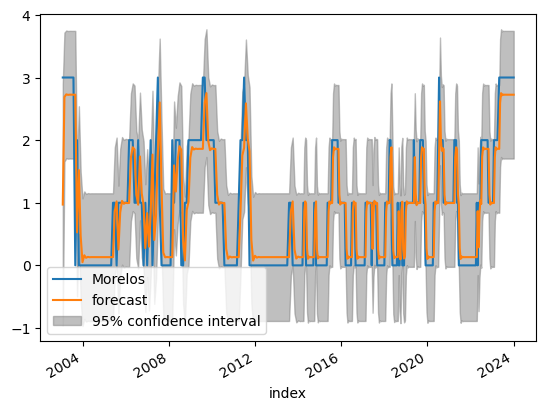

In [58]:
fig, ax = plt.subplots()
ax = df_new2["Morelos"].plot(ax=ax)
fig= plot_predict(model_fit_Mor,ax=ax, dynamic=False)
plt.show()

#### Out-of-Time Cross validation
Splitting the data into train and test to do Out-of-Time Cross validation

In [59]:
Morelos=df_new2["Morelos"]
Morelos

index
2003-01-31    3
2003-02-28    3
2003-03-31    3
2003-04-30    3
2003-05-31    3
             ..
2023-10-31    3
2023-11-15    3
2023-11-30    3
2023-12-15    3
2023-12-31    3
Name: Morelos, Length: 370, dtype: int32

In [60]:
p_train1 = 0.85

train1 = Morelos[:int(len(Morelos) * p_train1)]
test1 = Morelos[int(len(Morelos) * p_train1):]
train1

index
2003-01-31    3
2003-02-28    3
2003-03-31    3
2003-04-30    3
2003-05-31    3
             ..
2021-06-15    0
2021-06-30    0
2021-07-15    0
2021-07-31    0
2021-08-15    0
Name: Morelos, Length: 314, dtype: int32

Train dates : 2003-01-31 00:00:00 --- 2021-08-15 00:00:00  (n=314)
Test dates  : 2021-08-15 00:00:00 --- 2023-12-31 00:00:00  (n=57)


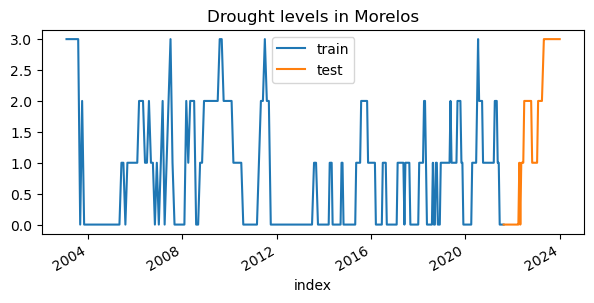

In [61]:
fin_train = '2021-08-15 00:00:00'
print(
    f"Train dates : {Morelos.index.min()} --- {Morelos.loc[:fin_train].index.max()}  "
    f"(n={len(Morelos.loc[:fin_train])})"
)
print(
    f"Test dates  : {Morelos.loc[fin_train:].index.min()} --- {Morelos.loc[:].index.max()}  "
    f"(n={len(Morelos.loc[fin_train:])})"
)
data_train = Morelos.loc[:fin_train]
data_test  = Morelos.loc[fin_train:]


fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Drought levels in Morelos')
ax.legend();

Applying the ARIMA model again using trainning data

In [62]:
modelM = ARIMA(data_train, order=(2,0,2))  
fitted = modelM.fit()  
print(fitted.summary())

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Morelos   No. Observations:                  314
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -251.752
Date:                Sat, 18 May 2024   AIC                            515.503
Time:                        21:39:29   BIC                            538.000
Sample:                             0   HQIC                           524.493
                                - 314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7923      0.173      4.576      0.000       0.453       1.132
ar.L1          0.3326      0.591      0.562      0.574      -0.826       1.492
ar.L2          0.3794      0.497      0.764      0.4

In [63]:
data_test.index
datdata = pd.Series(data_test.index)

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


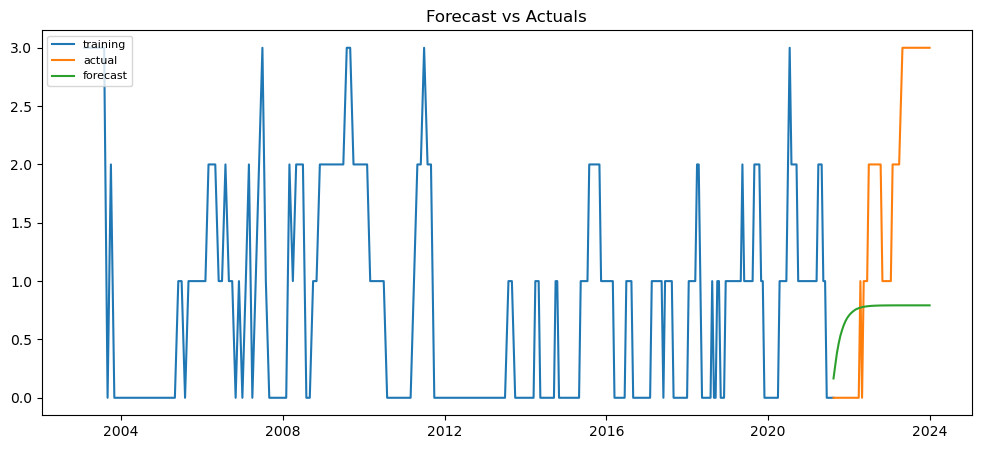

In [64]:
fc = fitted.forecast(57, alpha=0.05)  # 95% conf
conf= fitted.forecast(57, alpha=0.05) 

fc_series = pd.Series(fc.values, index=datdata)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train, label='training')
plt.plot(data_test, label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [65]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
                         # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc.values, data_test.values)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\3820999033.py:2: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\3820999033.py:5: RuntimeWarning: divide by zero encountered in divide
  mpe = np.mean((forecast - actual)/actual)   # MPE


{'mape': inf,
 'me': -0.7906651679707022,
 'mae': 1.1528780299039263,
 'mpe': inf,
 'rmse': 1.3838447749887062,
 'corr': 0.546293951488008,
 'minmax': 0.6930871372675147}

#### Auto Arima 

In [66]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(Morelos, start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
warnings.filterwarnings("ignore", category=DeprecationWarning)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=586.143, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1248.935, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=595.294, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=964.820, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=588.096, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=588.122, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=809.443, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=586.135, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=588.120, Time=0.37 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=590.095, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=576.020, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=581.032, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=577.788, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=577.683, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=576.

The AIC has reduced to 576 from 579 and The Log-likelihood did not improve, the model did not fit the data correctly.

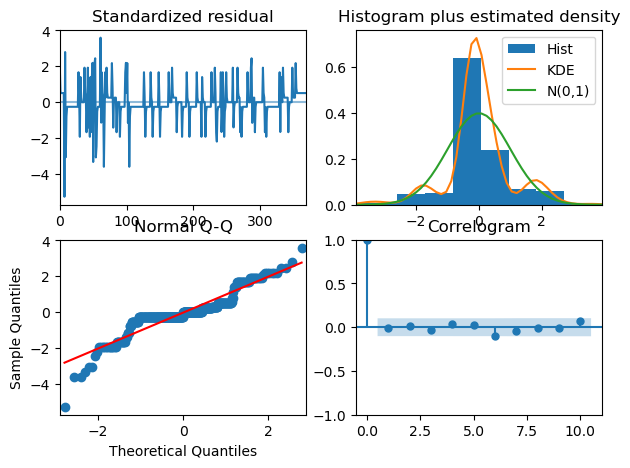

In [67]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In the first plot, the residual deviates significantly from zero. Considering that our predicted values range from 0 to 4, having an error of 1 or 2 is substantial and not accurate.

In [68]:
n_periods = 26 
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### Results:

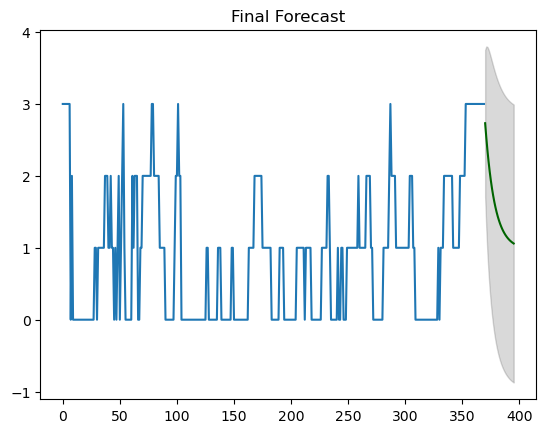

In [69]:
index_of_fc = np.arange(len(Morelos), len(Morelos)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc.values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(Morelos.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.show()

In [70]:
f_Morelos=fc_series
f_Morelos

370    2.732266
371    2.537061
372    2.357608
373    2.199699
374    2.059682
375    1.935697
376    1.825883
377    1.728623
378    1.642482
379    1.566189
380    1.498619
381    1.438773
382    1.385769
383    1.338824
384    1.297247
385    1.260422
386    1.227808
387    1.198922
388    1.173338
389    1.150679
390    1.130611
391    1.112837
392    1.097095
393    1.083152
394    1.070804
395    1.059867
dtype: float64

## COLIMA (Pacific Region)

In [71]:
from statsmodels.tsa.arima.model import ARIMA
print(valuesmodel["Colima"])

d    0
q    2
p    2
Name: Colima, dtype: int64


In [72]:
#( arima p d q )
model_G = ARIMA(df_new2["Colima"], order=(2,0,2))
model_fit_G = model_G.fit()
print(model_fit_G.summary())

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Colima   No. Observations:                  370
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -344.795
Date:                Sat, 18 May 2024   AIC                            701.590
Time:                        21:39:32   BIC                            725.071
Sample:                             0   HQIC                           710.917
                                - 370                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9733      0.180      5.415      0.000       0.621       1.326
ar.L1          1.3829      0.462      2.991      0.003       0.477       2.289
ar.L2         -0.4903      0.370     -1.324      0.1

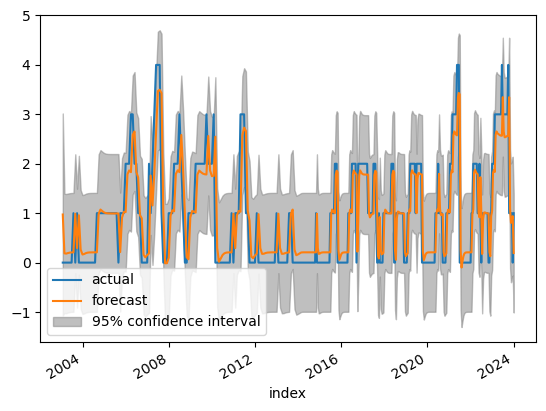

In [73]:
fig, ax = plt.subplots()
ax = df_new2["Colima"].plot(ax=ax,label='actual')
fig= plot_predict(model_fit_G, ax=ax,dynamic=False)

plt.show()

#### Out-of-Time Cross validation
Splitting the data into train and test to do Out-of-Time Cross validation

In [74]:
Colima=df_new2["Colima"]
Colima

index
2003-01-31    0
2003-02-28    0
2003-03-31    0
2003-04-30    0
2003-05-31    0
             ..
2023-10-31    1
2023-11-15    1
2023-11-30    1
2023-12-15    0
2023-12-31    1
Name: Colima, Length: 370, dtype: int32

In [75]:
p_train1 = 0.85

train1 = Colima[:int(len(Colima) * p_train1)]
test1 = Colima[int(len(Colima) * p_train1):]
train1

index
2003-01-31    0
2003-02-28    0
2003-03-31    0
2003-04-30    0
2003-05-31    0
             ..
2021-06-15    4
2021-06-30    0
2021-07-15    0
2021-07-31    0
2021-08-15    0
Name: Colima, Length: 314, dtype: int32

Train dates : 2003-01-31 00:00:00 --- 2021-08-15 00:00:00  (n=314)
Test dates  : 2021-08-15 00:00:00 --- 2023-12-31 00:00:00  (n=57)


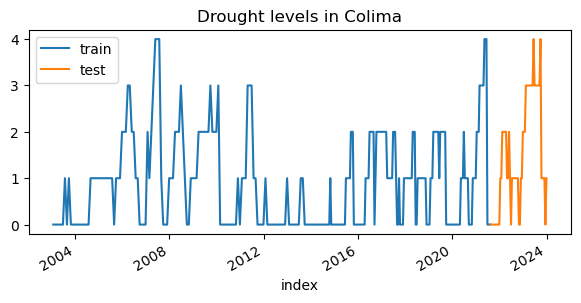

In [76]:
fin_train = '2021-08-15 00:00:00'
print(
    f"Train dates : {Colima.index.min()} --- {Colima.loc[:fin_train].index.max()}  "
    f"(n={len(Colima.loc[:fin_train])})"
)
print(
    f"Test dates  : {Colima.loc[fin_train:].index.min()} --- {Colima.loc[:].index.max()}  "
    f"(n={len(Colima.loc[fin_train:])})"
)
data_train = Colima.loc[:fin_train]
data_test  = Colima.loc[fin_train:]


fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Drought levels in Colima')
ax.legend();

In [77]:
modelC = ARIMA(data_train, order=(2,0,2))  
fitted = modelC.fit()  
print(fitted.summary())

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Colima   No. Observations:                  314
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -288.729
Date:                Sat, 18 May 2024   AIC                            589.457
Time:                        21:39:33   BIC                            611.954
Sample:                             0   HQIC                           598.446
                                - 314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8753      0.173      5.053      0.000       0.536       1.215
ar.L1          1.2557      0.488      2.572      0.010       0.299       2.212
ar.L2         -0.4141      0.377     -1.098      0.2

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


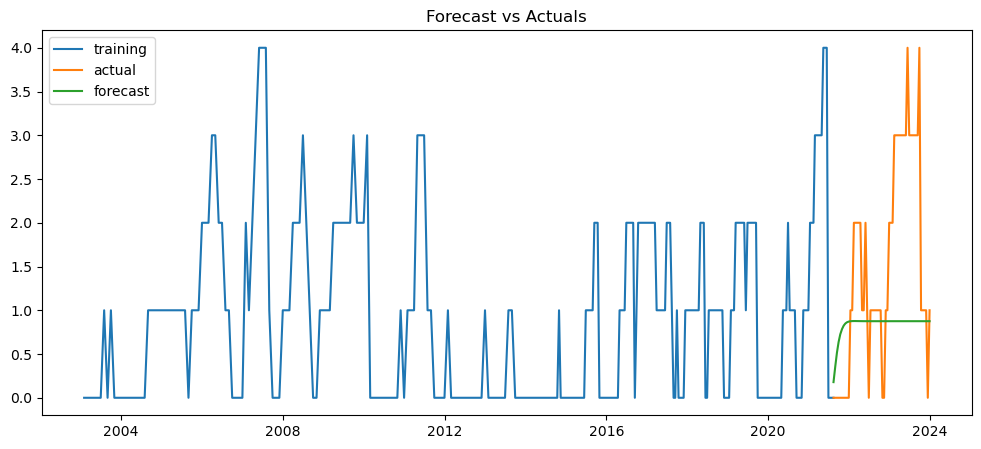

In [78]:
fc = fitted.forecast(57, alpha=0.05)  # 95% conf
conf= fitted.forecast(57, alpha=0.05) 
fc_series = pd.Series(fc.values, index=datdata)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train, label='training')
plt.plot(data_test, label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.show()

#### Metrics:

In [79]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
                         # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc.values, data_test.values)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\3820999033.py:2: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\3820999033.py:5: RuntimeWarning: divide by zero encountered in divide
  mpe = np.mean((forecast - actual)/actual)   # MPE


{'mape': inf,
 'me': -0.6358780861048975,
 'mae': 0.9905869575407585,
 'mpe': inf,
 'rmse': 1.3100374871241802,
 'corr': 0.3739537712024041,
 'minmax': 0.5648269669296109}

#### Auto Arima 

In [80]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(Colima, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
warnings.filterwarnings("ignore", category=DeprecationWarning)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=714.569, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1318.833, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=714.615, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1033.116, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=716.247, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=716.331, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=894.307, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=714.463, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=716.292, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=718.249, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=699.986, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=698.309, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1087.336, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=700.033, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=86

The AIC has reduced to 698 from 701. 

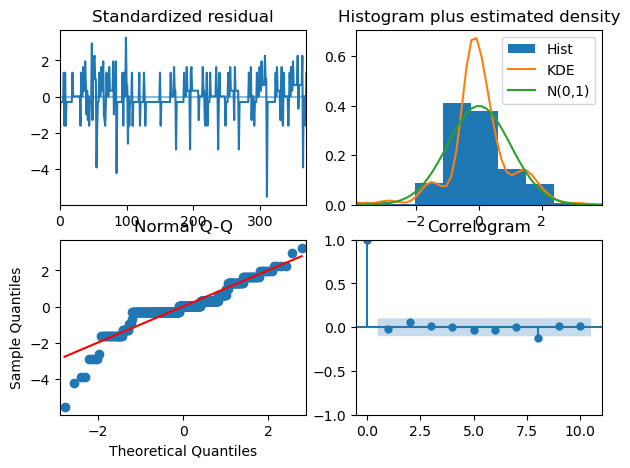

In [81]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [82]:
n_periods = 26
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


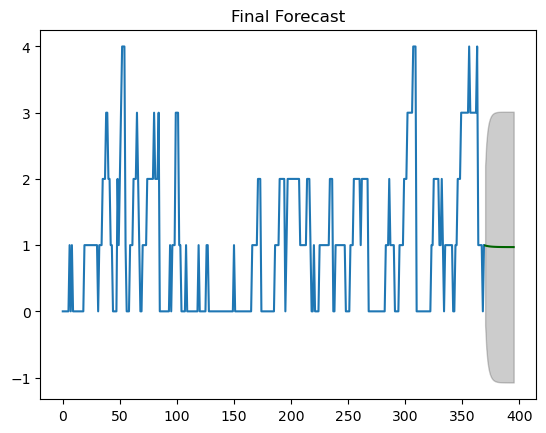

In [83]:
index_of_fc = np.arange(len(Colima), len(Colima)+n_periods)


fc_series = pd.Series(fc.values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


plt.plot(Colima.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.2)

plt.title("Final Forecast")
plt.show()

In [84]:
f_Colima=fc_series
f_Colima

370    0.994293
371    0.989686
372    0.985967
373    0.982966
374    0.980543
375    0.978587
376    0.977008
377    0.975734
378    0.974706
379    0.973875
380    0.973205
381    0.972664
382    0.972228
383    0.971875
384    0.971591
385    0.971361
386    0.971176
387    0.971026
388    0.970905
389    0.970808
390    0.970729
391    0.970666
392    0.970614
393    0.970573
394    0.970540
395    0.970513
dtype: float64

## QUINTANA ROO (Southern Region)

In [85]:
print(valuesmodel["Quintana Roo"])

d    0
q    2
p    2
Name: Quintana Roo, dtype: int64


In [86]:
from statsmodels.tsa.arima.model import ARIMA
# arima (p d q)
model_O = ARIMA(df_new2["Quintana Roo"], order=(2,0,2))
# Training arima modeling 
model_fit_O = model_O.fit()
print(model_fit_O.summary())

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Quintana Roo   No. Observations:                  370
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -293.197
Date:                Sat, 18 May 2024   AIC                            598.394
Time:                        21:39:35   BIC                            621.875
Sample:                             0   HQIC                           607.721
                                - 370                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1779      0.192      6.122      0.000       0.801       1.555
ar.L1         -0.0929      0.054     -1.735      0.083      -0.198       0.012
ar.L2          0.8206      0.045     18.361      0.0

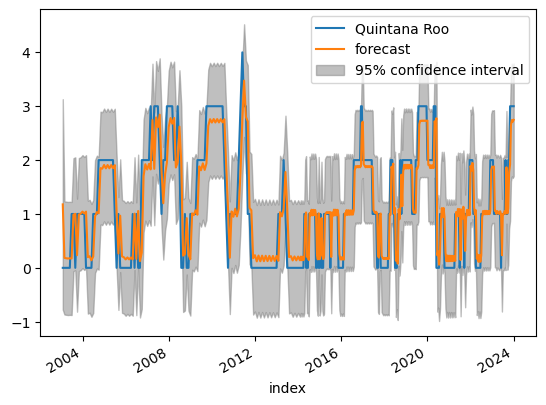

In [87]:
fig, ax = plt.subplots()
x = df_new2["Quintana Roo"].plot(ax=ax)
fig= plot_predict(model_fit_O, ax=ax, dynamic=False)
plt.show()

#### Out-of-Time Cross validation

In [88]:
Quintana=df_new2["Quintana Roo"]
Quintana

index
2003-01-31    0
2003-02-28    0
2003-03-31    0
2003-04-30    0
2003-05-31    0
             ..
2023-10-31    3
2023-11-15    3
2023-11-30    3
2023-12-15    3
2023-12-31    3
Name: Quintana Roo, Length: 370, dtype: int32

In [89]:
p_train1 = 0.85

train1 = Quintana[:int(len(Quintana) * p_train1)]
test1 = Quintana[int(len(Quintana) * p_train1):]
train1

index
2003-01-31    0
2003-02-28    0
2003-03-31    0
2003-04-30    0
2003-05-31    0
             ..
2021-06-15    1
2021-06-30    0
2021-07-15    1
2021-07-31    1
2021-08-15    1
Name: Quintana Roo, Length: 314, dtype: int32

Train dates : 2003-01-31 00:00:00 --- 2021-08-15 00:00:00  (n=314)
Test dates  : 2021-08-15 00:00:00 --- 2023-12-31 00:00:00  (n=57)


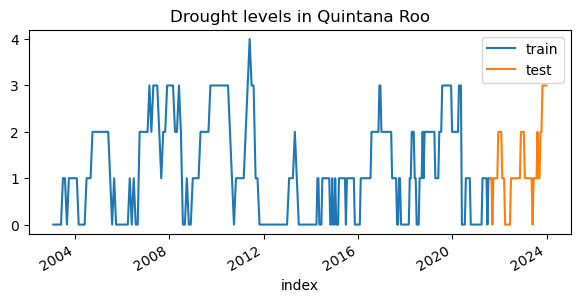

In [90]:
fin_train = '2021-08-15 00:00:00'
print(
    f"Train dates : {Quintana.index.min()} --- {Quintana.loc[:fin_train].index.max()}  "
    f"(n={len(Quintana.loc[:fin_train])})"
)
print(
    f"Test dates  : {Quintana.loc[fin_train:].index.min()} --- {Quintana.loc[:].index.max()}  "
    f"(n={len(Quintana.loc[fin_train:])})"
)
data_train = Quintana.loc[:fin_train]
data_test  = Quintana.loc[fin_train:]


fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Drought levels in Quintana Roo')
ax.legend();

In [91]:
modelQ = ARIMA(data_train, order=(2,0,2))  
fitted = modelQ.fit()  
print(fitted.summary())


C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Quintana Roo   No. Observations:                  314
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -254.728
Date:                Sat, 18 May 2024   AIC                            521.456
Time:                        21:39:36   BIC                            543.952
Sample:                             0   HQIC                           530.445
                                - 314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1329      0.213      5.319      0.000       0.715       1.550
ar.L1         -0.0975      0.086     -1.128      0.259      -0.267       0.072
ar.L2          0.8174      0.064     12.731      0.0

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


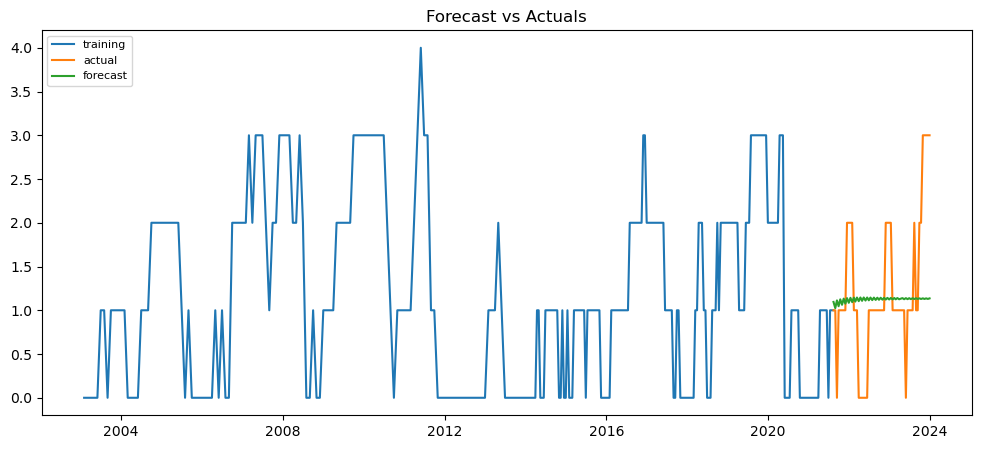

In [92]:


fc = fitted.forecast(57, alpha=0.05)  
conf= fitted.forecast(57, alpha=0.05) 

fc_series1 = pd.Series(fc.values, index=datdata)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train, label='training')
plt.plot(data_test, label='actual')
plt.plot(fc_series1, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Metrics:

In [93]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) 
    me = np.mean(forecast - actual)             
    mae = np.mean(np.abs(forecast - actual))    
    mpe = np.mean((forecast - actual)/actual)   
    rmse = np.mean((forecast - actual)**2)**.5  
    corr = np.corrcoef(forecast, actual)[0,1]   
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             
                         # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc.values, data_test.values)


C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\3820999033.py:2: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
C:\Users\dnisg\AppData\Local\Temp\ipykernel_1364\3820999033.py:5: RuntimeWarning: divide by zero encountered in divide
  mpe = np.mean((forecast - actual)/actual)   # MPE


{'mape': inf,
 'me': -0.10454387928938709,
 'mae': 0.5603780180862202,
 'mpe': inf,
 'rmse': 0.8001748337050231,
 'corr': 0.08787424800675657,
 'minmax': 0.3412174622343389}

#### Auto Arima 

In [94]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(Quintana, start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
warnings.filterwarnings("ignore", category=DeprecationWarning)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=611.696, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1365.800, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=613.018, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1031.606, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=613.366, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=885.252, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=611.941, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=612.250, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=597.524, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=795.563, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=596.239, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1043.477, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=597.513, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=599.51

The AIC has reduced to 596 from 598. 

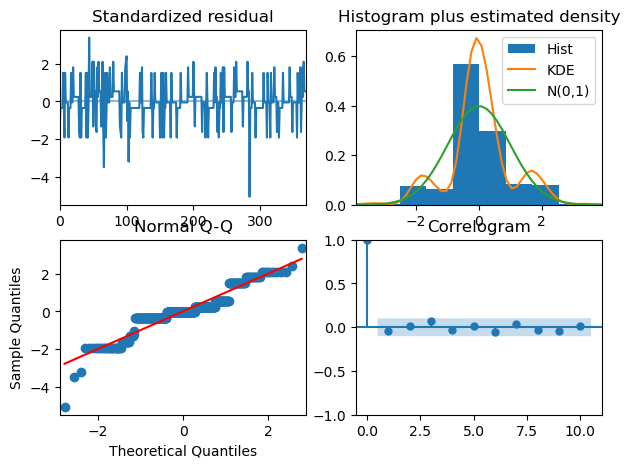

In [95]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [96]:
n_periods = 26 
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### Results:

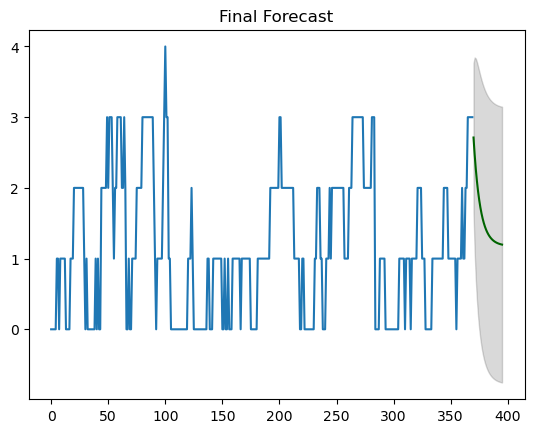

In [97]:
index_of_fc = np.arange(len(Quintana), len(Quintana)+n_periods)


fc_series = pd.Series(fc.values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(Quintana.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.show()

In [98]:
f_Quintana=fc_series
f_Quintana

370    2.712474
371    2.470293
372    2.266307
373    2.094491
374    1.949773
375    1.827878
376    1.725207
377    1.638728
378    1.565888
379    1.504535
380    1.452859
381    1.409332
382    1.372670
383    1.341790
384    1.315780
385    1.293872
386    1.275419
387    1.259876
388    1.246785
389    1.235758
390    1.226470
391    1.218647
392    1.212058
393    1.206508
394    1.201833
395    1.197896
dtype: float64

#### Comparing the 4 data series

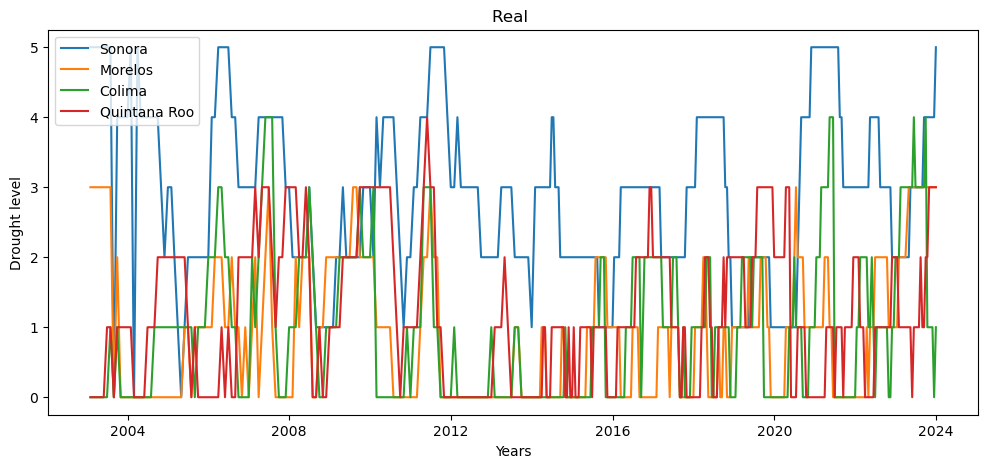

In [99]:
plt.figure(figsize=(12,5))
plt.plot(Sonora,label="Sonora")
plt.plot(Morelos,label="Morelos")
plt.plot(Colima,label="Colima")
plt.plot(Quintana,label="Quintana Roo")

plt.title('Real ')
plt.legend(loc='upper left', fontsize=10)
plt.xlabel("Years")
plt.ylabel("Drought level")
plt.show()

In [100]:
Morelos.mean()

0.8918918918918919

In [101]:
Quintana.mean()

1.1675675675675676

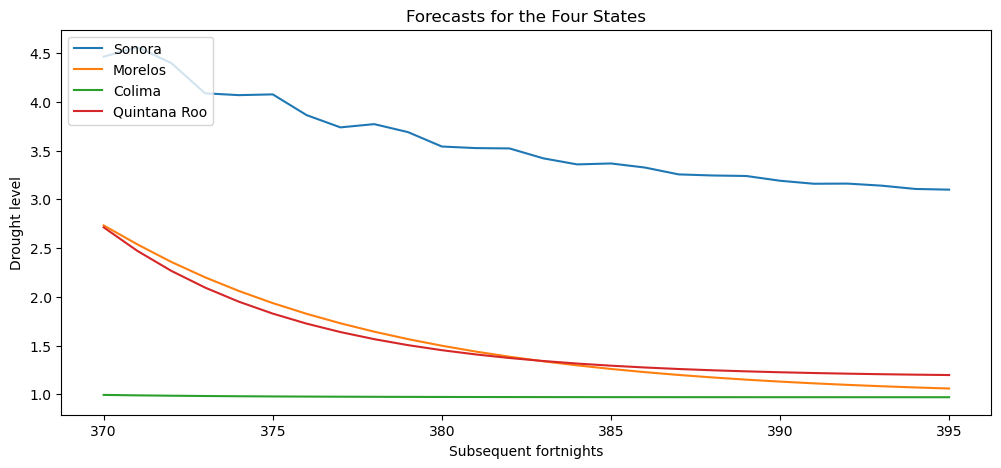

In [102]:
plt.figure(figsize=(12,5))
plt.plot(f_Sonora,label="Sonora")
plt.plot(f_Morelos,label="Morelos")
plt.plot(f_Colima,label="Colima")
plt.plot(f_Quintana,label="Quintana Roo")

plt.title('Forecasts for the Four States')
plt.legend(loc='upper left', fontsize=10)
plt.xlabel("Subsequent fortnights")
plt.ylabel("Drought level")
plt.show()

#### Conclusion:
The models are not functioning correctly to forecast the entire year. Despite using one model for each state, the results for all were very poor. They all show a downward trend, and their values are not distributed across the 5 levels; instead, they all tend to approach 1.

Sonora had the highest levels, and compared to the others, its forecast fluctuates between 2 levels. It is observed that it rises and falls slightly, but not as expected, since it remains within the same range.
Morelos and Quintana Roo have very similar results, despite Quintana Roo having a higher mean (1.167, compared to Morelos' 0.89). 

In comparison, Colima performed the worst, as its values never exceeded 1 and remained linear. As we have seen in its graph, Colima's values are typically distributed across the 4 drought levels.

Although various actions were taken to train our model with the best parameters, we need to further improve our data series and spend more time understanding the ARIMA model fully to comprehend what might be causing these results.


That is why the graphs and metrics we obtained were not discussed in detail, as they all would have shown incorrect results due to our model being poorly trained

This will be addressed as future actions.